# Final Project Submission

Please fill out:
* Student name: Heath Rittler
* Student pace: Self paced 
* Scheduled project review date/time: 10/28/2022
* Instructor name: Mark Barbour
* Blog post URL: https://medium.com/@heathlikethecandybar/


# Introduction

## Business Case/ Summary

My business stakeholder is the owner of a local real estate agency.  The agency focuses on home improvement recommendations to homeowners that will optimize the buying and selling of their homes.  I will be deciphering which home improvements lead to the most value of a home.  The output of my analysis will show 3 features that will impact the value of a home.  Each one of these features should be in control of the homesowner, meaning they will be able to make those changes if they so desire before listing their home.

### Core Field Names and Definitions from Data Source
The dataset comes from King County, in Washington state.  The data in its raw form consists of 21 columns, and 21,597 records before any cleaning or feature engineering.  More information on the columns and definitions can be found in the repository here (data/column_names.md).  Any further information regarding the dataset can be found at the King County website (https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * Additional details below
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


#### Additional Details - Building Condition Defintions
Relative to age and grade. Coded 1-5.

* `1 = Poor-Worn out` Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

* `2 = Fair-Badly worn` Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

* `3 = Average` Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

* `4 = Good` No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

* `5 = Very Good` All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.

Residential Building Grades
* `Grades 1 - 3` Falls short of minimum building standards. Normally cabin or inferior structure.
* `Grade 4` Generally older low quality construction. Does not meet code.
* `Grade 5` Lower construction costs and workmanship. Small, simple design.
* `Grade 6` Lowest grade currently meeting building codes. Low quality materials, simple
designs.
* `Grade 7` Average grade of construction and design. Commonly seen in plats and older
subdivisions.
* `Grade 8` Just above average in construction and design. Usually better materials in both
the exterior and interior finishes.
* `Grade 9` Better architectural design, with extra exterior and interior design and quality.
* `Grade 10` Homes of this quality generally have high quality features. Finish work is better,
and more design quality is seen in the floor plans and larger square footage.
* `Grade 11` Custom design and higher quality finish work, with added amenities of solid
woods, bathroom fixtures and more luxurious options.
* `Grade 12` Custom design and excellent builders. All materials are of the highest quality
and all conveniences are present.
* `Grade 13` Generally custom designed and built. Approaching the Mansion level. Large
amount of highest quality cabinet work, wood trim and marble; large entries.

# Data Load, Cleaning, & Exploratory

 ## Package load

In [1]:
# Importing packages for analysis

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
lr = LinearRegression()
plt.style.use('seaborn-talk')
import sklearn.metrics as metrics

%matplotlib inline

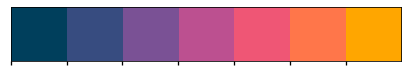

In [2]:
# Choosing standard colors for project

pal = ['#003f5c',
        '#374c80',
        '#7a5195',
        '#bc5090',
        '#ef5675',
        '#ff764a',
        '#ffa600']

color_codes = ['darkblue', 'indigo', 'purple', 'pink', 'peach', 'orange', 'yellow']

c = lambda x: pal[color_codes.index(x)]

sns.palplot(sns.color_palette(pal))

Ooo that's pretty.  Let's take a look now at our data -- coming from a csv.

## Load

In [3]:
# Here we go!  Read csv, look at initial shape

df = pd.read_csv('data/kc_house_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Because my stakeholder and business proposition is recommending enhancements for homeowners, I am going to remove the features that are not impactable by the hoemowner.  (i.e. Homeowner can't change the fact that they are or are not on waterfront)

In [4]:
# Removing waterfront, view, lat, long, zipcode from dataframe

df_clean = df.drop(
    ['waterfront', 'view', 'lat', 'long', 'zipcode'], axis=1)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   grade          21597 non-null  object 
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  sqft_living15  21597 non-null  int64  
 15  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(8), object(4)
memory usage: 2.6+ MB


In [5]:
# Digging into object/ string fields to understand how we will transform.  First
# suspect is sqft_basement, would assume numeric values and 0 for no basement.

df_clean['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
276.0         1
2580.0        1
768.0         1
415.0         1
1930.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [6]:
# Changing basement sqft column.  Adjusting ? to 0.0, and changing data type
# to numeric in order to feed model.

df_clean['sqft_basement'] = df_clean['sqft_basement'].replace(['?'],'0.0')

df_clean['sqft_basement'].astype(float)

df_clean['sqft_basement'].value_counts();

In [7]:
# Digging into yr_renovated

df_clean['yr_renovated'].value_counts();

In [8]:
# Not a ton of values, so going to add a boolean feature = is renovated

conditions = [df_clean.loc[:,'yr_renovated'] > 0,
              df_clean.loc[:,'yr_renovated'] == 0]

values = [1,0]

df_clean.loc[:,'is_renovated'] = np.select(conditions, values, default=0)

df_clean['is_renovated'].value_counts();

In [9]:
# Adding another column with the count of years between yr built and renovation 'yr_frm_btr'

conditions = [
    (df_clean['yr_renovated'] == 0),
    (df_clean['yr_renovated'] > 0)
    ]

# Create a list of the values we want to assign for each condition
values = [0, (df_clean['yr_renovated'] - df_clean['yr_built'])]

# Create a new column and use np.select to assign values to it using our lists as arguments
df['yr_frm_btr'] = np.select(conditions, values);

In [10]:
# Dropping the yr_renovated column.  Don't necessarily need it right now

df_clean = df_clean.drop('yr_renovated', axis = 1)

In [11]:
# Another look again at info

df_clean.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   grade          21597 non-null  object 
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
 15  is_renovated   21597 non-null  int64  
dtypes: float64(3), int64(9), object(4)
memory usage: 2.6+ MB


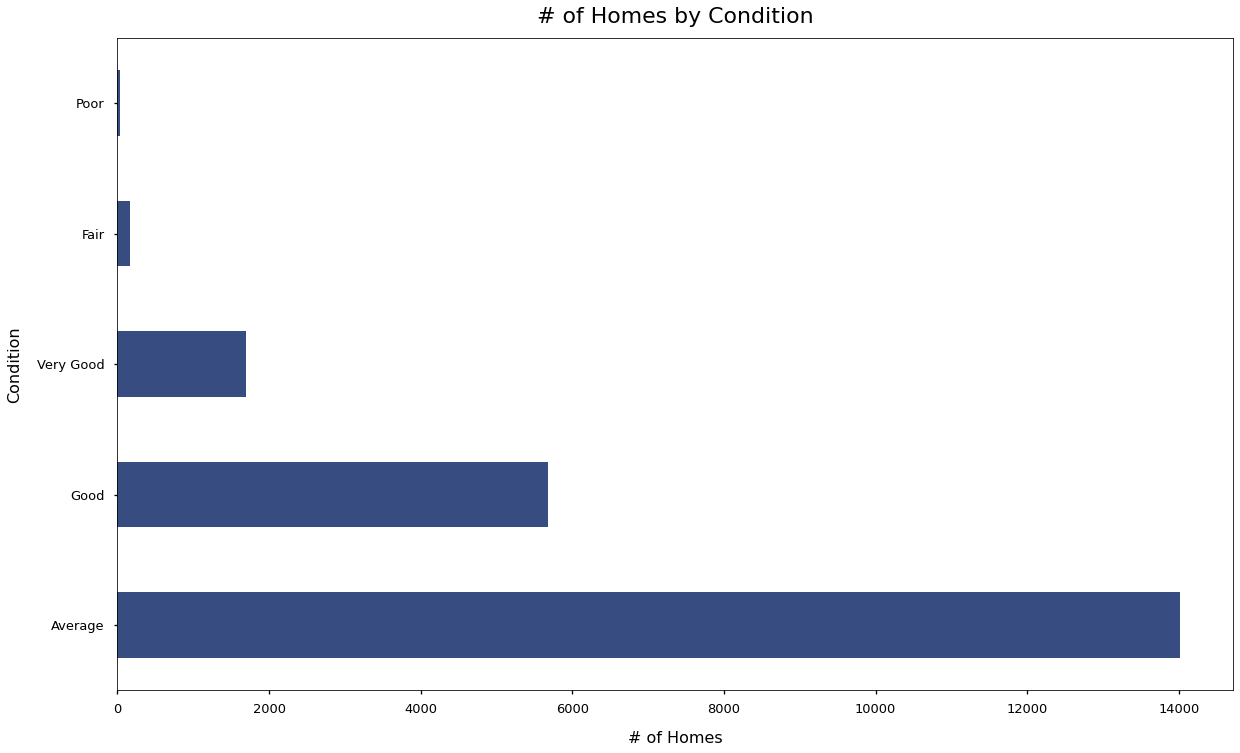

In [12]:
# Checking out condition; will need to one hot encode these columns

fig, ax = plt.subplots(figsize = (20,12))

df_clean['condition'].value_counts().plot(kind='barh', color=c("indigo"))


ax.set_title('# of Homes by Condition', pad = 15, fontsize = 22)
ax.set_xlabel('# of Homes', labelpad = 15, fontsize = 16)
ax.set_ylabel('Condition', labelpad = 15, fontsize = 16) 

plt.show();

This breakdown is a little disappointing.  There really isn't a great distribution of condition.  Everything is listed as good, and above.  Going to look at grade to see if that
has a better distribution before encoding.

In [13]:
# Checking out grade; going to strip string so we can make column numeric.

df_clean['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [14]:
# Split column and add new columns to df

gd_sp = df_clean['grade'].str.split(' ', n = 1, expand = True)

# Add column names
gd_sp.columns = ['grade_num', "grade_cat"]

# Concat back to df_clean dataframe
df_clean = pd.concat([df_clean, gd_sp], axis = 1)

# Update grade_num column to int datatype
df_clean['grade_num'] = df_clean['grade_num'].astype(int)

In [15]:
# Dropping original column from dataframe

df_clean = df_clean.drop(['grade'], axis = 1)

# Checking df_clean to see where we are at.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
 14  is_renovated   21597 non-null  int64  
 15  grade_num      21597 non-null  int64  
 16  grade_cat      21597 non-null  object 
dtypes: float64(3), int64(10), object(4)
memory usage: 

In [16]:
# Adding ratio of above ground square footage to square footage of living area.  
# Trying to understand if their is more living square footage below ground, 
# is that attractive to a home buyer.

df_clean.loc[:,'sqft_a/l'] = (
    df_clean['sqft_above'] / df_clean['sqft_living']
    )

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,grade_cat,sqft_a/l
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,Average,1180,0.0,1955,1340,5650,0,7,Average,1.000000
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,Average,2170,400.0,1951,1690,7639,1,7,Average,0.844358
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,Average,770,0.0,1933,2720,8062,0,6,Low Average,1.000000
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,Very Good,1050,910.0,1965,1360,5000,0,7,Average,0.535714
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,Average,1680,0.0,1987,1800,7503,0,8,Good,1.000000


In [17]:
# Building ratio for living square footage to # of bedrooms.

df_clean.loc[:,'sqft_l/b'] = (
    round(df_clean['sqft_living'] / df_clean['bedrooms'],2)
    )

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,grade_cat,sqft_a/l,sqft_l/b
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,Average,1180,0.0,1955,1340,5650,0,7,Average,1.000000,393.33
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,Average,2170,400.0,1951,1690,7639,1,7,Average,0.844358,856.67
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,Average,770,0.0,1933,2720,8062,0,6,Low Average,1.000000,385.00
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,Very Good,1050,910.0,1965,1360,5000,0,7,Average,0.535714,490.00
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,Average,1680,0.0,1987,1800,7503,0,8,Good,1.000000,560.00


In [18]:
# Look for missing data/ na's

df_clean.isna().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
condition        False
sqft_above       False
sqft_basement    False
yr_built         False
sqft_living15    False
sqft_lot15       False
is_renovated     False
grade_num        False
grade_cat        False
sqft_a/l         False
sqft_l/b         False
dtype: bool

In [19]:
# Taking another peek to see what is left to clean or transform

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
 14  is_renovated   21597 non-null  int64  
 15  grade_num      21597 non-null  int64  
 16  grade_cat      21597 non-null  object 
 17  sqft_a/l       21597 non-null  float64
 18  sqft_l

In [20]:
# OHE categoricals final categoricals

categoricals = ['condition', 'grade_cat']

dummies = pd.get_dummies(df_clean[categoricals], 
                         prefix=categoricals, 
                         drop_first=True)

df_preprocessed = df_clean.drop(categoricals, axis=1)

df_clean = pd.concat([df_preprocessed, dummies], axis=1)

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,1180,0.0,...,0,0,0,0,0,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,2170,400.0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,770,0.0,...,0,0,0,0,0,1,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,1050,910.0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,1680,0.0,...,0,0,0,1,0,0,0,0,0,0


In [21]:
# Cleaning final sqft_basement column, and dropping the date/ id column for now

df_clean = df_clean.drop('date', axis=1)
df_clean = df_clean.drop('id', axis=1)
df_clean['sqft_basement'] = df_clean['sqft_basement'].astype(float)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  21597 non-null  float64
 1   bedrooms               21597 non-null  int64  
 2   bathrooms              21597 non-null  float64
 3   sqft_living            21597 non-null  int64  
 4   sqft_lot               21597 non-null  int64  
 5   floors                 21597 non-null  float64
 6   sqft_above             21597 non-null  int64  
 7   sqft_basement          21597 non-null  float64
 8   yr_built               21597 non-null  int64  
 9   sqft_living15          21597 non-null  int64  
 10  sqft_lot15             21597 non-null  int64  
 11  is_renovated           21597 non-null  int64  
 12  grade_num              21597 non-null  int64  
 13  sqft_a/l               21597 non-null  float64
 14  sqft_l/b               21597 non-null  float64
 15  co

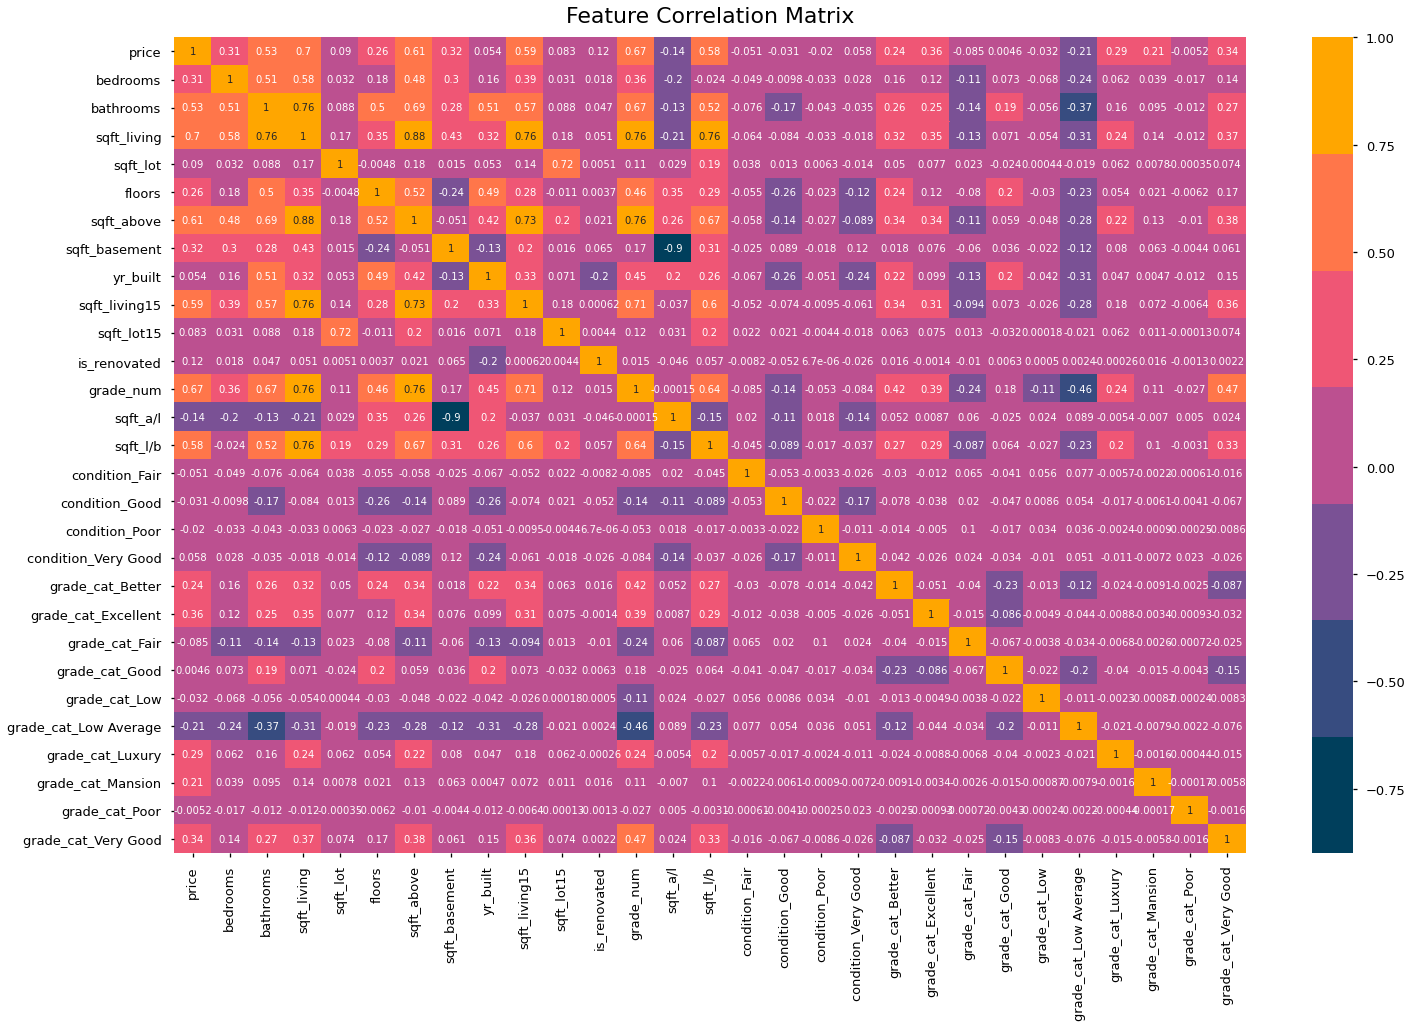

In [22]:
# Early correlation matrix to understand relationships with what we currently have.

fig, ax = plt.subplots(figsize=(24,15))
corrM = df_clean.corr()

ax.set_title('Feature Correlation Matrix', pad=15, fontsize=22)

sns.heatmap(corrM, annot=True, cmap=pal)
plt.show()

Looks like bathrooms, sqft_living, sqft_above, sqft_lot15, and condition fair, all have decent (>.50) r2 with our dependent variable price.  We will see later if the the p-value of these independent variables are strong enough for us to continue to evaluate these variables as having the ability to predict price.  Unfortunately, we cannot do anything about the sqft_lot15 independent variable, so we will most likely be dropping this feature.

Since we have grade_num, I am going to remove the grade_cat breakouts.  Doesn't seem like they are helping much anyways.  We can always add them back in, but fewer features may make more sense going into our baseline.

In [23]:
# Removing the grade category OHE features.

df_clean = df_clean.drop(df_clean.iloc[:,15:], axis=1)
df_clean

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,sqft_a/l,sqft_l/b
0,221900.0,3,1.00,1180,5650,1.0,1180,0.0,1955,1340,5650,0,7,1.000000,393.33
1,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,1690,7639,1,7,0.844358,856.67
2,180000.0,2,1.00,770,10000,1.0,770,0.0,1933,2720,8062,0,6,1.000000,385.00
3,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,1360,5000,0,7,0.535714,490.00
4,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,1800,7503,0,8,1.000000,560.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,1530,0.0,2009,1530,1509,0,8,1.000000,510.00
21593,400000.0,4,2.50,2310,5813,2.0,2310,0.0,2014,1830,7200,0,8,1.000000,577.50
21594,402101.0,2,0.75,1020,1350,2.0,1020,0.0,2009,1020,2007,0,7,1.000000,510.00
21595,400000.0,3,2.50,1600,2388,2.0,1600,0.0,2004,1410,1287,0,8,1.000000,533.33


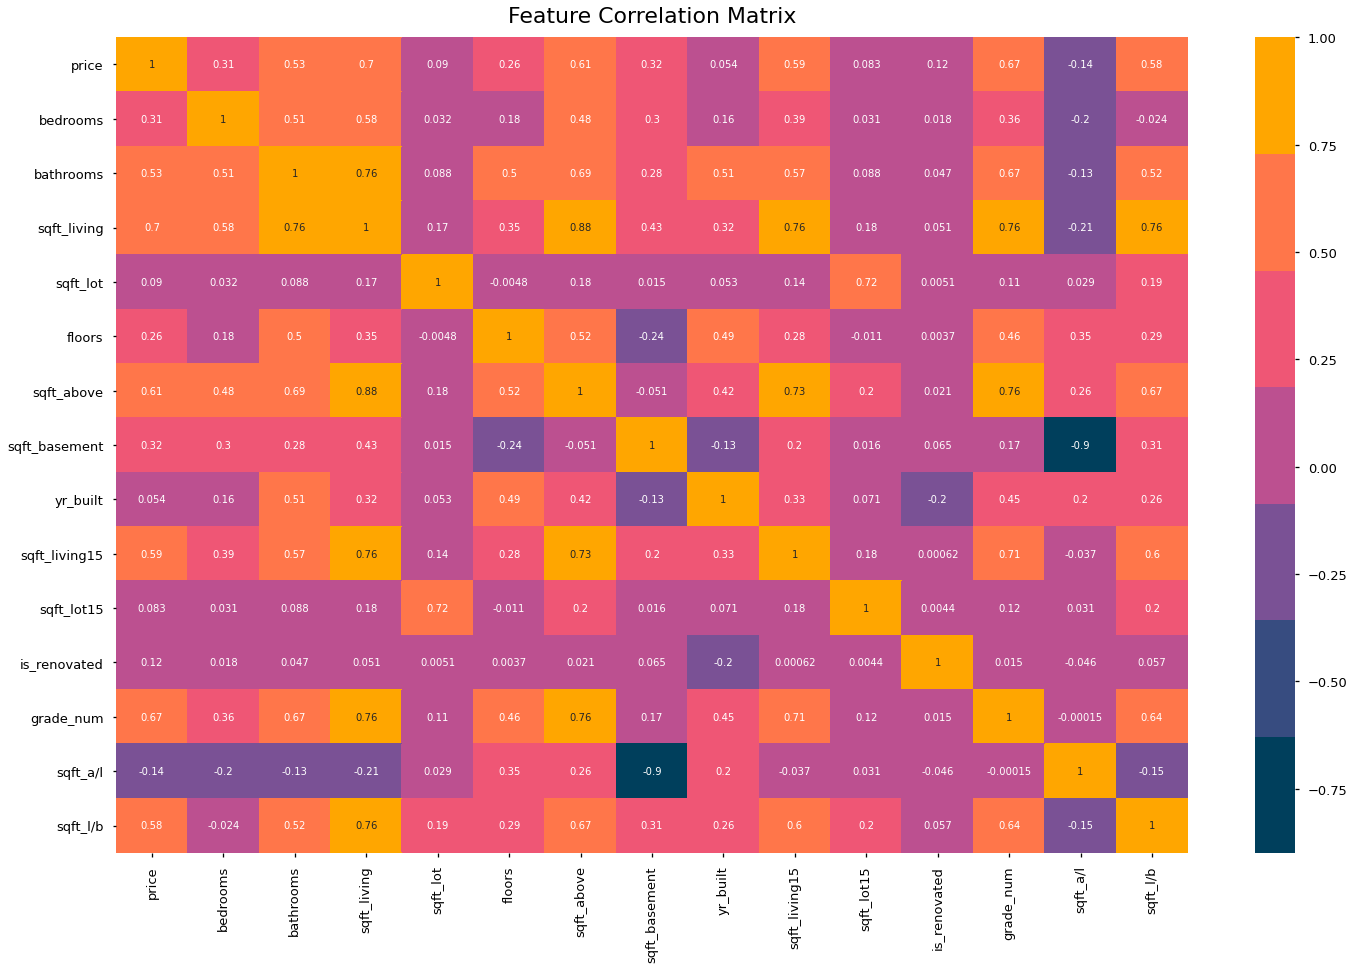

In [24]:
# Early correlation matrix to understand relationships with what we currently have.

fig, ax = plt.subplots(figsize=(24,15))
corrM = df_clean.corr()

ax.set_title('Feature Correlation Matrix', pad=15, fontsize=22)

sns.heatmap(corrM, annot=True, cmap=pal)
plt.show()

## Exploratory Data Analysis

I am going to first focus on 3 variables that have traditionally been included when determining the price of a house, the number of bedrooms, the number of bathrooms, and the square footage of the living area.  I am going to dig into these individually, and then look at the broader data before running any regressions.

In [25]:
# Look at initial distributions of columns

df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,sqft_a/l,sqft_l/b
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,285.716581,1970.999676,1986.620318,12758.283512,0.034449,7.657915,0.875406,618.147927
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,439.819830,29.375234,685.230472,27274.441950,0.182384,1.173200,0.170999,215.899031
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,0.000000,1900.000000,399.000000,651.000000,0.000000,3.000000,0.333333,49.090000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,0.000000,1951.000000,1490.000000,5100.000000,0.000000,7.000000,0.725610,470.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,1975.000000,1840.000000,7620.000000,0.000000,7.000000,1.000000,576.670000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,550.000000,1997.000000,2360.000000,10083.000000,0.000000,8.000000,1.000000,722.500000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000,2015.000000,6210.000000,871200.000000,1.000000,13.000000,1.000000,3420.000000


Average price is 540k, and median price is 450k, suggesting that there are some outliers driving the average higher than the median number.  This is also realized with bedrooms, sqft_living.  Which makes sense if we have some higher cost houses.  Conventional thought, I would expect those to be similarly distributed as the price because that is what I think typically drives the price of a house.  Another interesting component is yr_built.  With how we think about houses evolving (i.e. # of bathrooms, square footage, etc) from 1900-2015, I am assuming we will see some interesting things with price as it is associated with homes over time.

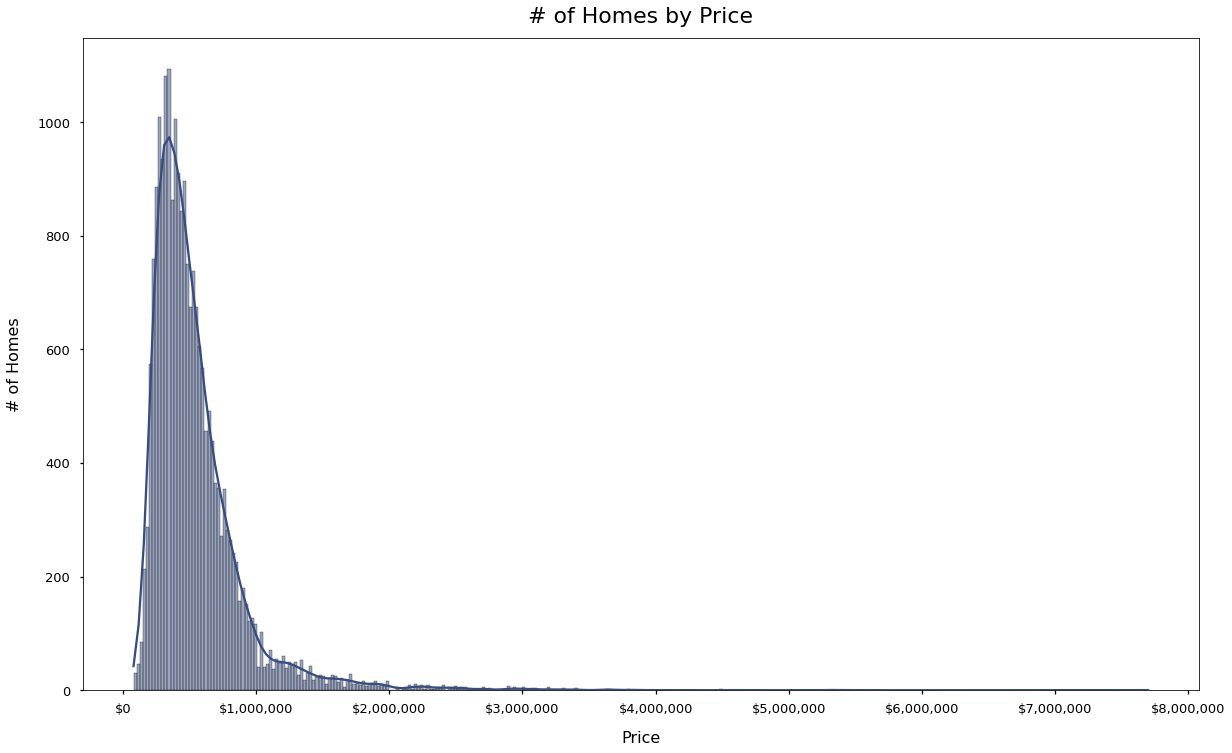

In [26]:
# Quick look at price, our dependent variable

fig, ax = plt.subplots(figsize=(20,12))

sns.histplot(data=df_clean, 
             x='price', 
             kde=True, 
             color=c("indigo"))

ax.set_title('# of Homes by Price', pad=15, fontsize=22)
ax.set_xlabel('Price', labelpad=15, fontsize=16)
ax.set_ylabel('# of Homes', labelpad=15, fontsize=16) 

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

plt.show();

Distribution seems to be right skewed.  Meaning that our mean is above our Median and being inflated by outliers (as mentioned above).  However not the end of the world at this point.  Going to continue to evaluate.

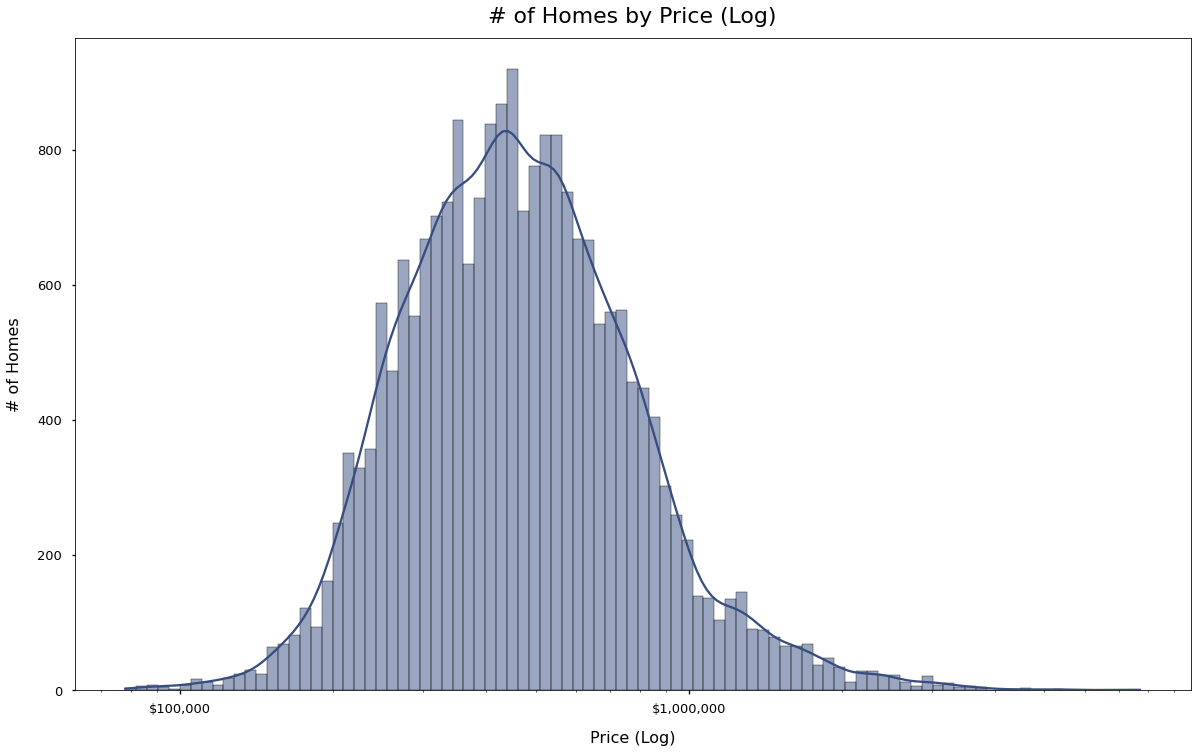

In [27]:
# Quick look at price, our dependent variable transformed as a log value

fig, ax = plt.subplots(figsize=(20,12))

sns.histplot(data=df_clean, 
             x='price', 
             kde=True, 
             log_scale=True, 
             color=c("indigo"))

ax.set_title('# of Homes by Price (Log)', pad=15, fontsize=22)
ax.set_xlabel('Price (Log)', labelpad=15, fontsize=16)
ax.set_ylabel('# of Homes', labelpad=15, fontsize=16) 

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

plt.show();

This looks much better.  I am going to keep my original values for the first values, but then will most likely change to a log scale in order to distribute the data normally.

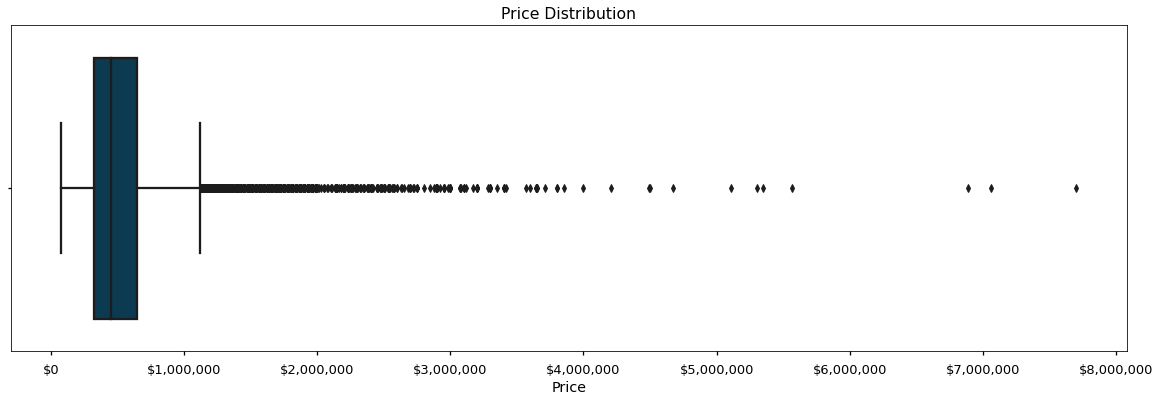

In [28]:
# Quick look at price distribution as it relates to a box plot/ distribution.

fig, ax = plt.subplots(figsize=(20,6))

ax.set_title('Price Distribution')


bp = sns.boxplot(data=df_clean, 
                 x='price',  
                 palette=pal)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

bp.set_xlabel('Price');

Going to check to see how many records we would drop if we remove outliers outside of IQR.


In [29]:
# Developing variables for IQR removal, and record count.

price_Q1 = df_clean['price'].quantile(0.25)
price_Q3 = df_clean['price'].quantile(0.75)

IQR = price_Q3 - price_Q1

lower_bnd = price_Q1 - 1.5 * IQR
upper_bnd = price_Q3 + 1.5 * IQR


In [30]:
# Creating variable for lower bound

outliers_low = df_clean['price'] > lower_bnd

In [31]:
# Creating variable for lower bound

outliers_up = df_clean['price'] < upper_bnd

In [32]:
print("% of Records Retained After Oulier Removal:", 
      "{:.1%}".format(len(df_clean['price'][~outliers_low | outliers_up])/ len(df_clean))
     )

% of Records Retained After Oulier Removal: 94.6%


The removal of outliers really doesn't impact our sample size.  Which is good.  We will most likely remove these outliers later as we iterate on our regression models.

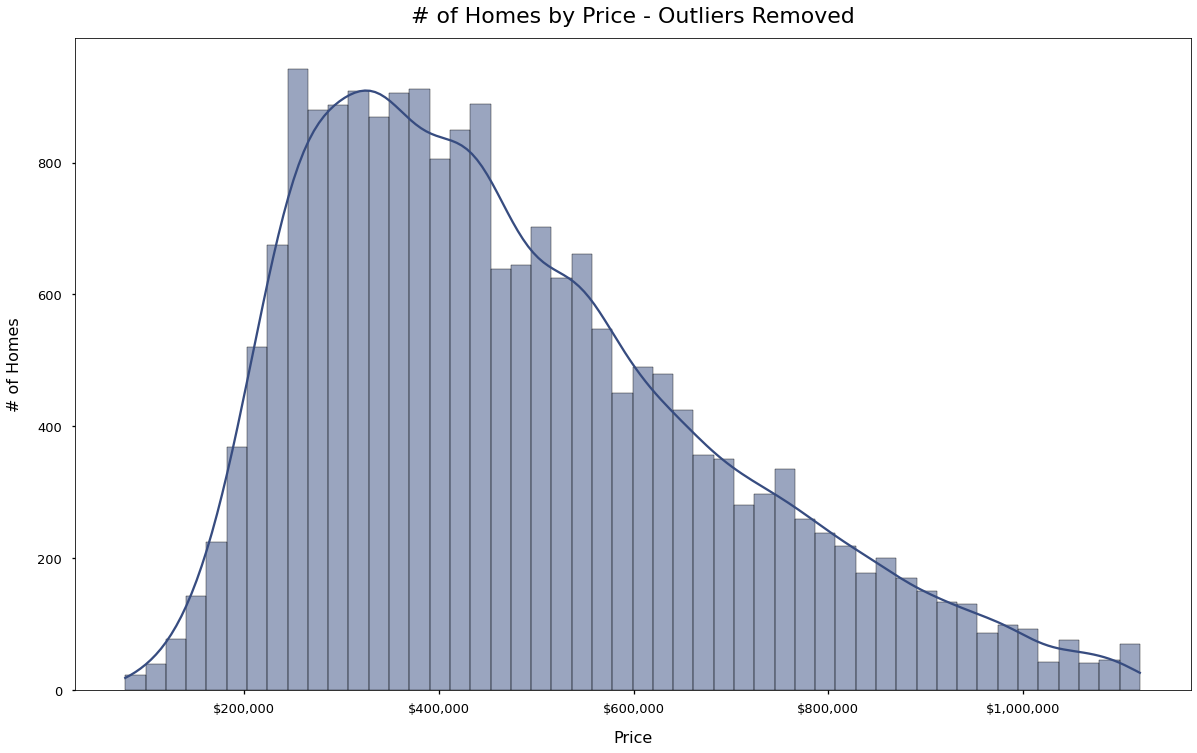

In [33]:
# Taking a look at the new distribution less outliers

price_check = df_clean['price'][~outliers_low | outliers_up]

fig, ax = plt.subplots(figsize=(20,12))

sns.histplot(data=price_check, 
             kde=True, 
             color=c("indigo"))

ax.set_title('# of Homes by Price - Outliers Removed', pad=15, fontsize=22)
ax.set_xlabel('Price', labelpad=15, fontsize=16)
ax.set_ylabel('# of Homes', labelpad=15, fontsize=16) 

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

plt.show();

This looks much better even without the log trasnformation.  What we are looking for is a normal distribution of data, which will ensure our model will have the best opportunity to be objective in its results/ predictions.

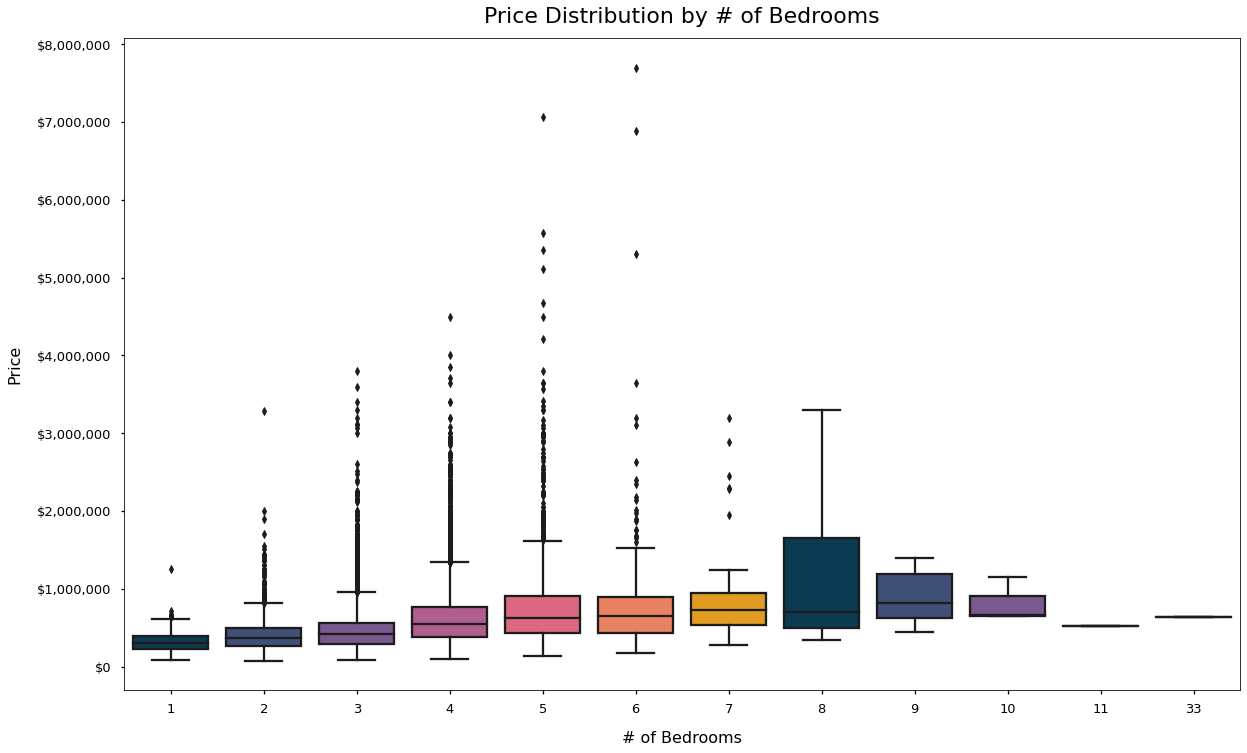

In [34]:
# Boxplots for # of bedrooms and price

fig, ax = plt.subplots(figsize=(20,12))

ax.set_title('Price Distribution by # of Bedrooms')

bp = sns.boxplot(data=df_clean, 
            y='price', 
            x='bedrooms', 
            palette=pal)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Price Distribution by # of Bedrooms', pad=15, fontsize=22)
ax.set_xlabel('# of Bedrooms', labelpad=15, fontsize=16)
ax.set_ylabel('Price', labelpad=15, fontsize=16) 

plt.show();

Removing outliers seems like it would be a good option.  Also probably easier than trying to interpret log transformed coefficients.  Will most likely try outlier removal first, then log transform.

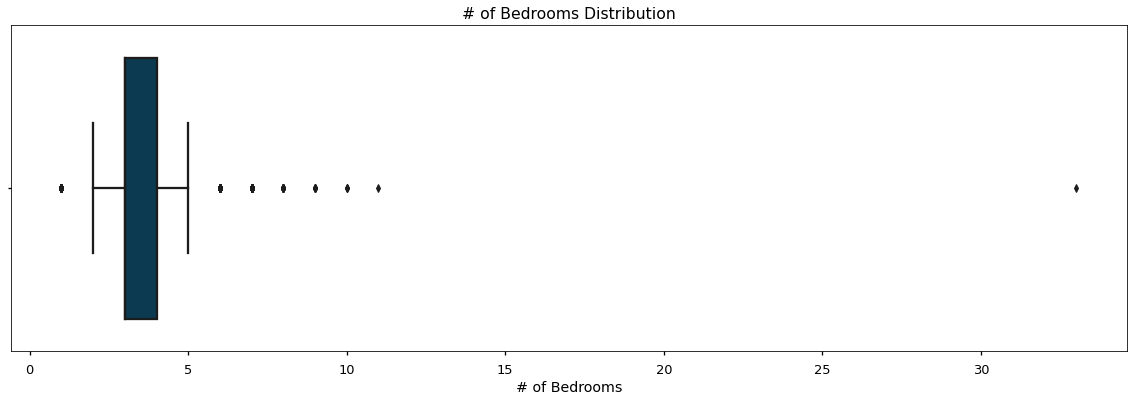

In [35]:
# Taking a look at bedrooms only

fig, ax = plt.subplots(figsize=(20,6))

ax.set_title('# of Bedrooms Distribution')

bp = sns.boxplot(data=df_clean, 
            x='bedrooms', 
            palette=pal)

bp.set_ylabel('')
bp.set_xlabel('# of Bedrooms')

plt.show();

There doesn't seem to be a large difference between the median home price, as the number of bedrooms increase.  In fact, most of the outliers for price, are situated within the non-outlier values of bedrooms.  With that being said, there does seem to be a subtle increase in price, as the number of bedrooms increase.  The one record with the 33 bedrooms is a bit bothersome, however it doesn't look like the house really got the benefit of having that many bedrooms because the price was just above the average, and the sqft_living is below the median.  To me this looks like an error in the data in that it should be represented as 3 bedrooms, instead of 33 bedrooms.  The median, and the 25th percentiles are the same for bedrooms, with 3 bedrooms.

In [36]:
# Isolating the bedroom row with 33 bedrooms for further inspection

df_clean.loc[df_clean['bedrooms'] == 33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,sqft_a/l,sqft_l/b
15856,640000.0,33,1.75,1620,6000,1.0,1040,580.0,1947,1330,4700,0,7,0.641975,49.09


In [37]:
# Replacing 33 bedroom value with 3 bedrooms

df_clean['bedrooms'] = df['bedrooms'].replace([33],3)

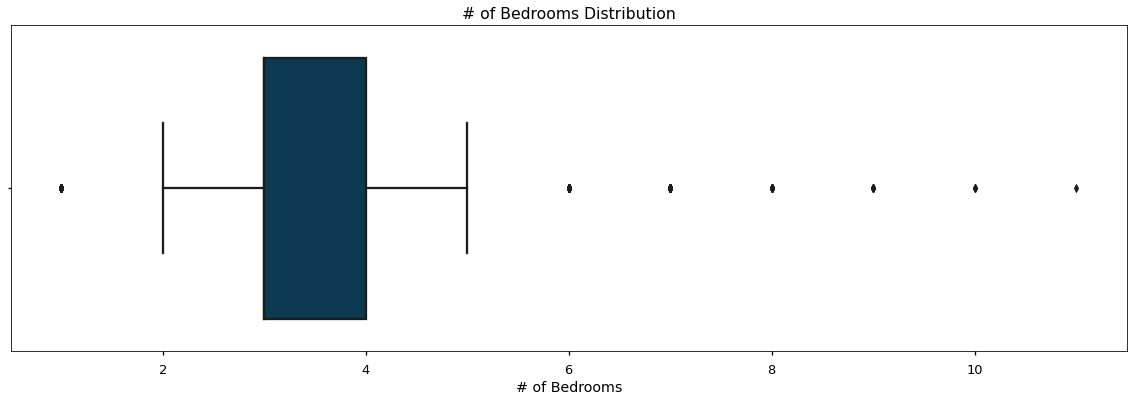

In [38]:
# Quick view to make sure our operation worked.

fig, ax = plt.subplots(figsize=(20,6))

ax.set_title('# of Bedrooms Distribution')

bp = sns.boxplot(data=df_clean, 
            x='bedrooms', 
            palette=pal)

bp.set_ylabel('')
bp.set_xlabel('# of Bedrooms')

plt.show();

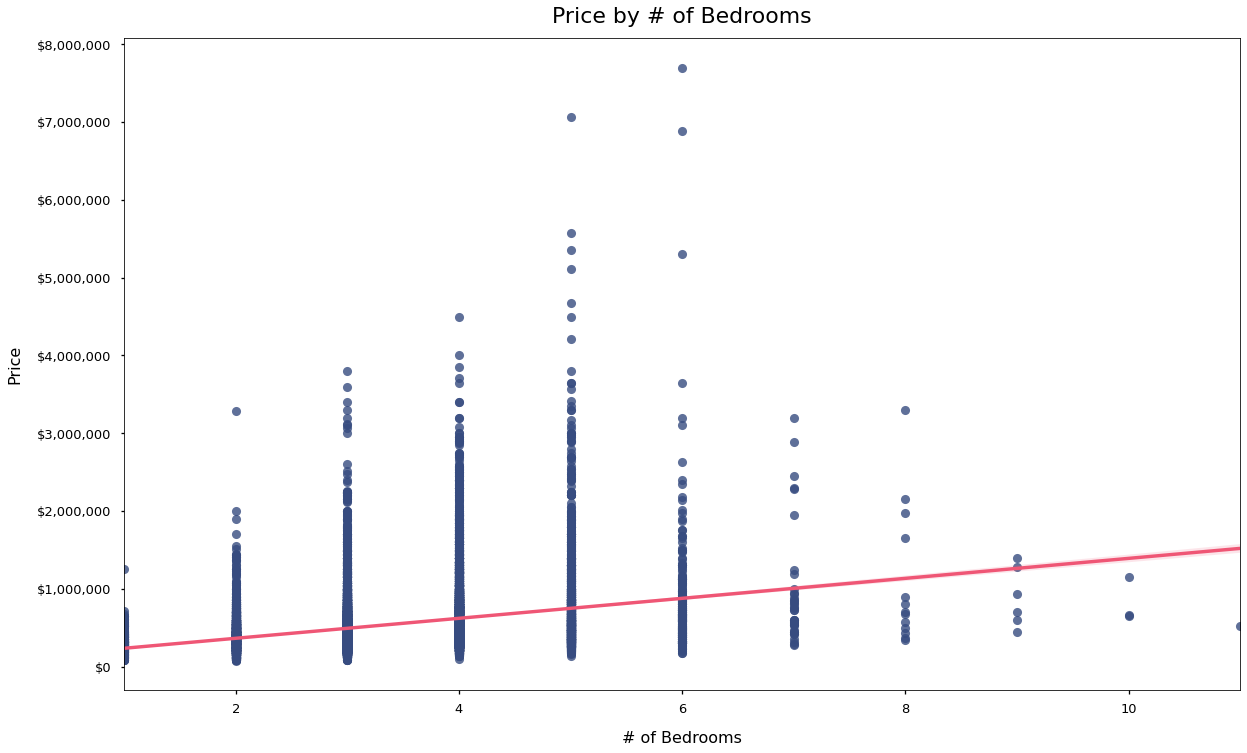

In [39]:
# Scatter to look at the data between our bedroom variable and price.

fig, ax = plt.subplots(figsize = (20,12))

sns.regplot(x='bedrooms',
            y='price', 
            data=df_clean,
            scatter_kws={"color": c("indigo")}, 
            line_kws={"color": c("peach")})

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Price by # of Bedrooms', pad=15, fontsize=22)
ax.set_xlabel('# of Bedrooms', labelpad=15, fontsize=16)
ax.set_ylabel('Price', labelpad=15, fontsize=16)

plt.show();

There seems to be a moderate positive relationship between the number of bedrooms and our price variable.  The data looks much more consistent without the 33 bedrooms.  I think the 33 bedrooms may have been inflating our expectations of the influence that bedrooms actually has on price.  There are a few outliers that remain, we will run a regression first and then determine if removing additional will be valuable.  Moving on to bathrooms next.

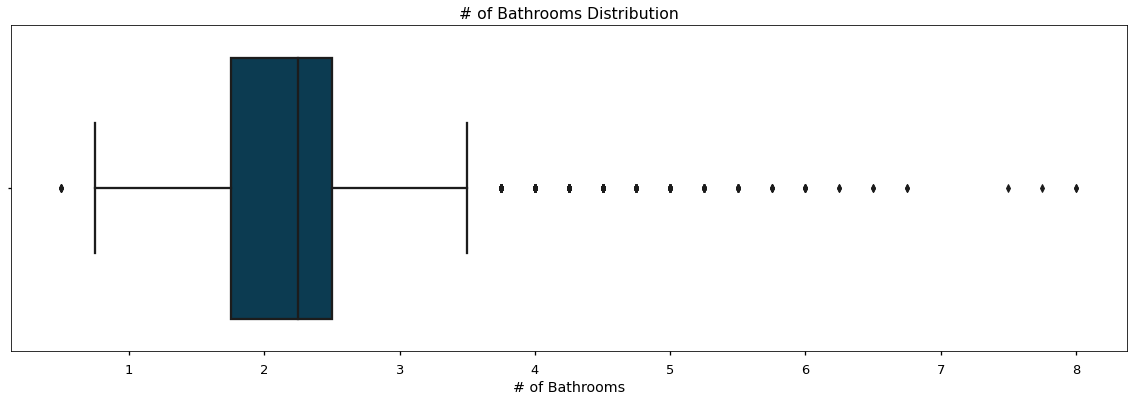

In [40]:
# Quick view to make sure our operation worked.

fig, ax = plt.subplots(figsize=(20,6))

ax.set_title('# of Bathrooms Distribution')

bp = sns.boxplot(data=df_clean, 
            x='bathrooms', 
            palette=pal)

bp.set_ylabel('')
bp.set_xlabel('# of Bathrooms')

plt.show();

A few outliers based on the boxplot, while most bathrooms are between .75 and 3.5.

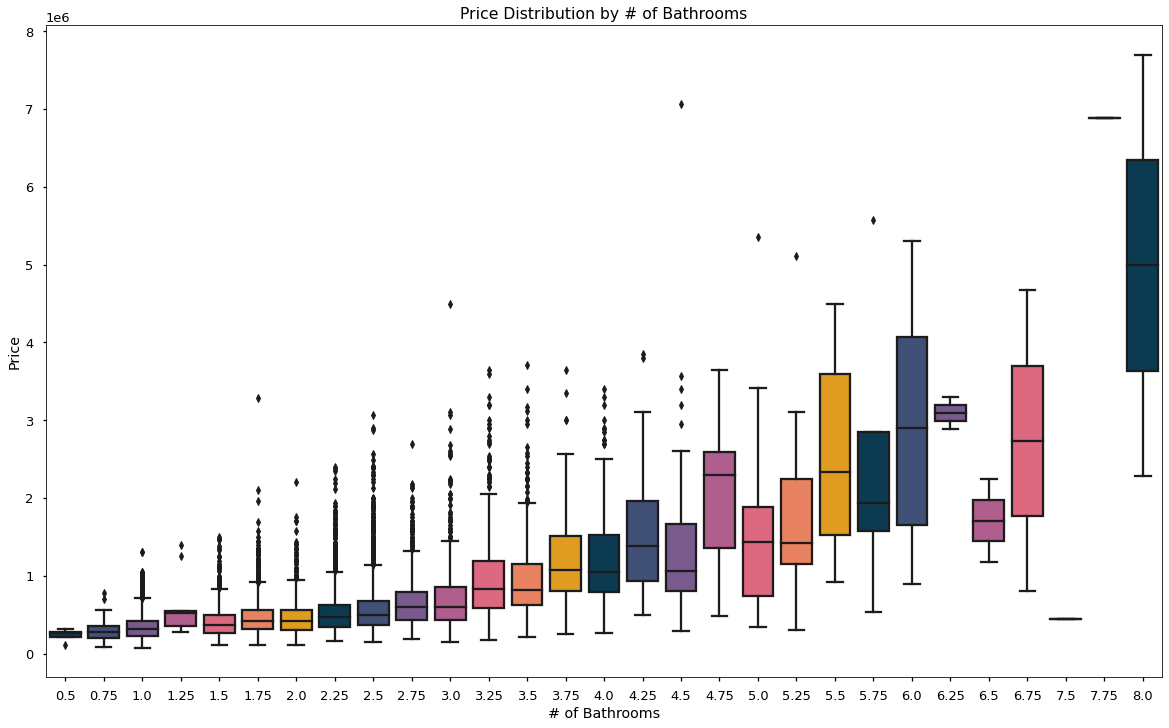

In [41]:
# Creating a chart for price distribution by number of bathrooms.  Trying to understand
# distribution within each bathroom size to see if outliers driving any values in our assumed linear 
# relationship.

fig, ax = plt.subplots(figsize=(20,12))

ax.set_title('Price Distribution by # of Bathrooms')

bp = sns.boxplot(data=df_clean, 
            y='price', 
            x='bathrooms', 
            palette=pal)

bp.set_ylabel('Price')
bp.set_xlabel('# of Bathrooms')

plt.show();

Not crazy about all these .25, and .75 baths.  Especially since the lower end of values have a lot of overlap in price distribution.  Going to create another column that rounds up to the nearest half bath.  

In [42]:
# Create a new column for rounded bathrooms.

df_clean['baths_rnd'] = (np.floor(df_clean['bathrooms'] * 2)/ 2)

In [43]:
# Quick view of our columns to make sure we're transforming the way we expect.

df_clean[['baths_rnd', 'bathrooms']]

,baths_rnd,bathrooms
0,1.0,1.00
1,2.0,2.25
2,1.0,1.00
3,3.0,3.00
4,2.0,2.00
...,...,...
21592,2.5,2.50
21593,2.5,2.50
21594,0.5,0.75
21595,2.5,2.50


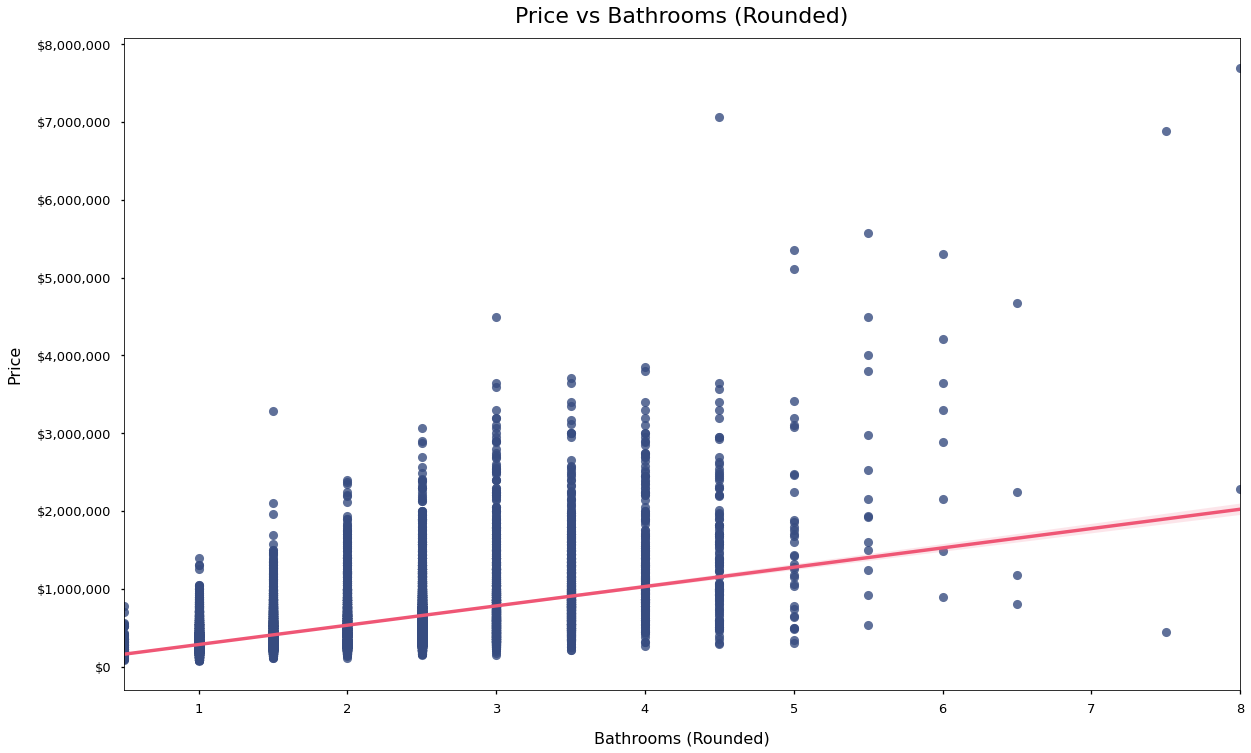

In [44]:
# Scatter plot for my rounded bathrooms and the 

fig, ax = plt.subplots(figsize=(20,12))


sns.regplot(x='baths_rnd',
            y='price', 
            data=df_clean,
            scatter_kws={"color": c("indigo")}, 
            line_kws={"color": c("peach")})

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Price vs Bathrooms (Rounded)', pad=15, fontsize=22)
ax.set_xlabel('Bathrooms (Rounded)', labelpad=15, fontsize=16)
ax.set_ylabel('Price', labelpad=15, fontsize=16)

plt.show();

Once again a slight correlation with price.  At a glance it looks like bathrooms have a stronger impact on price vs # the number of bedrooms listed on a house.  If this does turn out to be the case, then suggesting bathroom upgrades and potentially rounding up existing bathrooms would be easy enhancements to increase the value of a home for our customers.

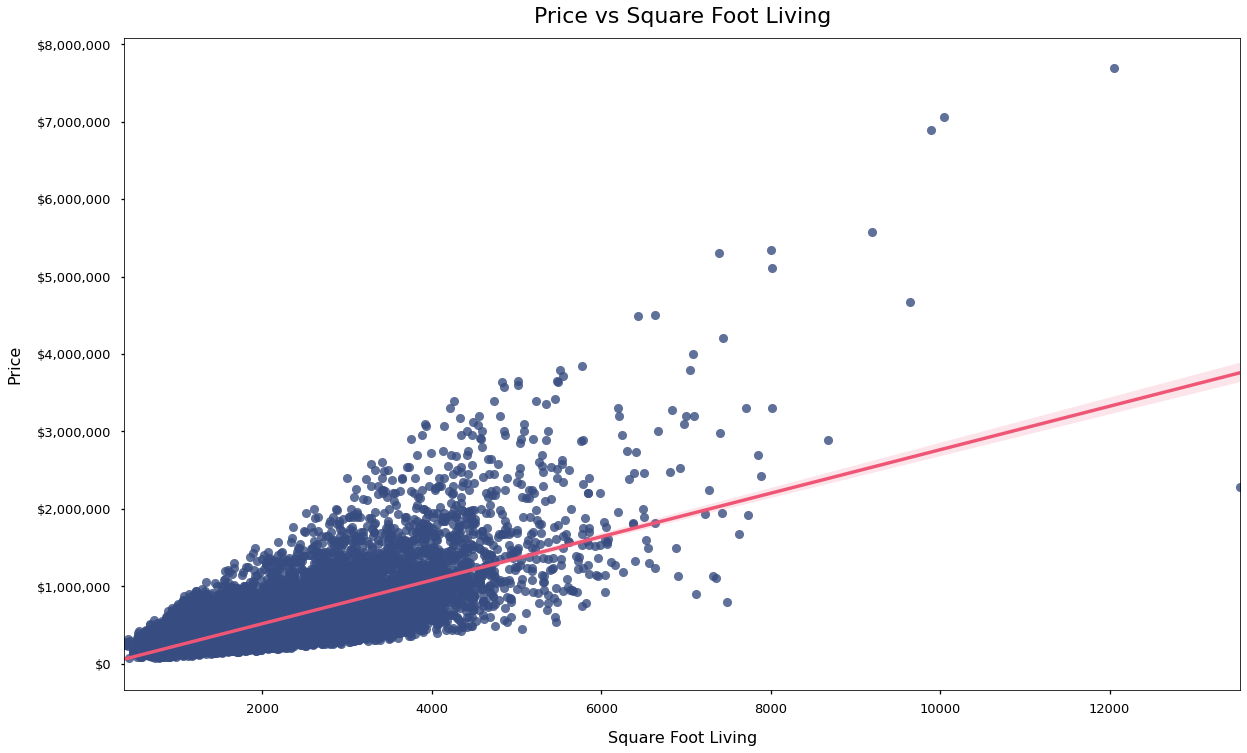

In [45]:
# Let's take a quick look at price vs living area square footage.

fig, ax = plt.subplots(figsize=(20,12))

sns.regplot(x='sqft_living',
            y='price', 
            data=df_clean,
            scatter_kws={"color": c("indigo")}, 
            line_kws={"color": c("peach")})

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Price vs Square Foot Living', pad=15, fontsize=22)
ax.set_xlabel('Square Foot Living', labelpad=15, fontsize=16)
ax.set_ylabel('Price', labelpad=15, fontsize=16)

plt.show();

So at a glance, it seems as if living area square footage will have the highest impact on the sale price of a home.  We will see if this holds true in our analysis/ regression.  In addition, we will assume that our rounded bathrooms will also have a larger impact on the overall price.

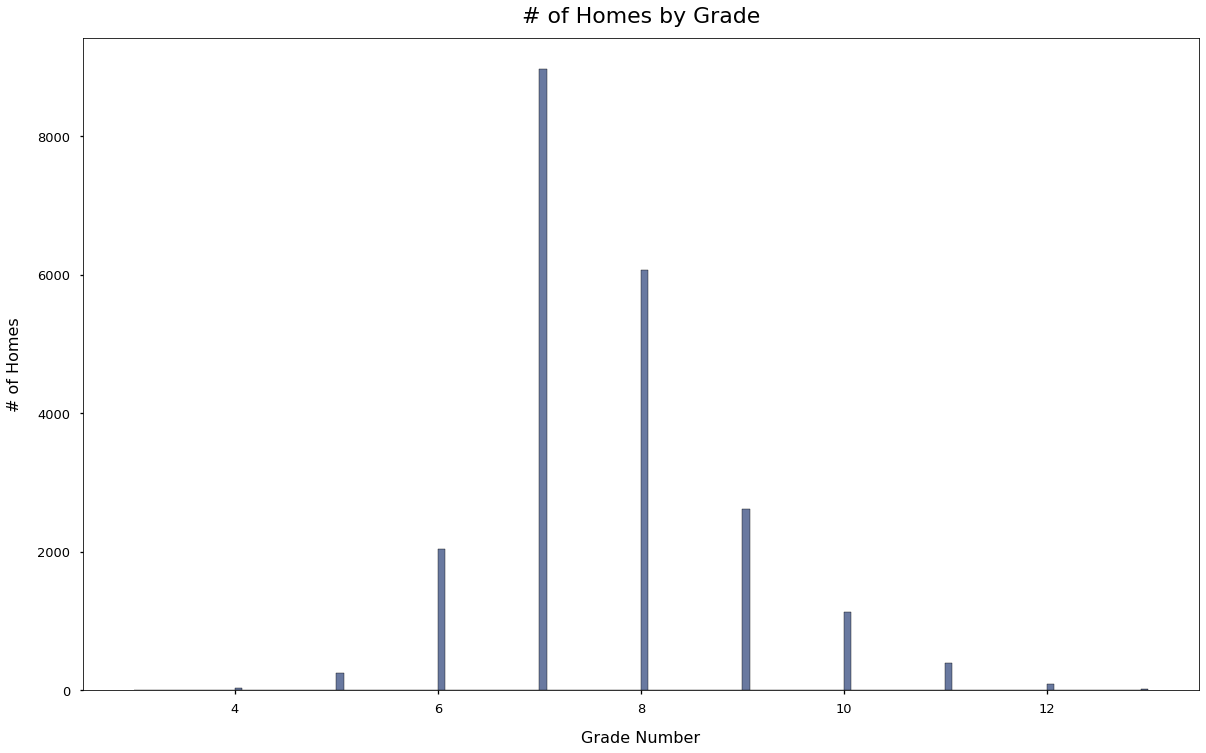

In [46]:
# Taking a look at our grade_num feature

fig, ax = plt.subplots(figsize=(20,12))

sns.histplot(data=df_clean, 
             x='grade_num',
             color=c("indigo"))

ax.set_title('# of Homes by Grade', pad=15, fontsize=22)
ax.set_xlabel('Grade Number', labelpad=15, fontsize=16)
ax.set_ylabel('# of Homes', labelpad=15, fontsize=16) 

plt.show();

Average grade_num is 7.65 while the median is 7.  Shows similar as majority of homes in this dataset have a rating of 6-9.

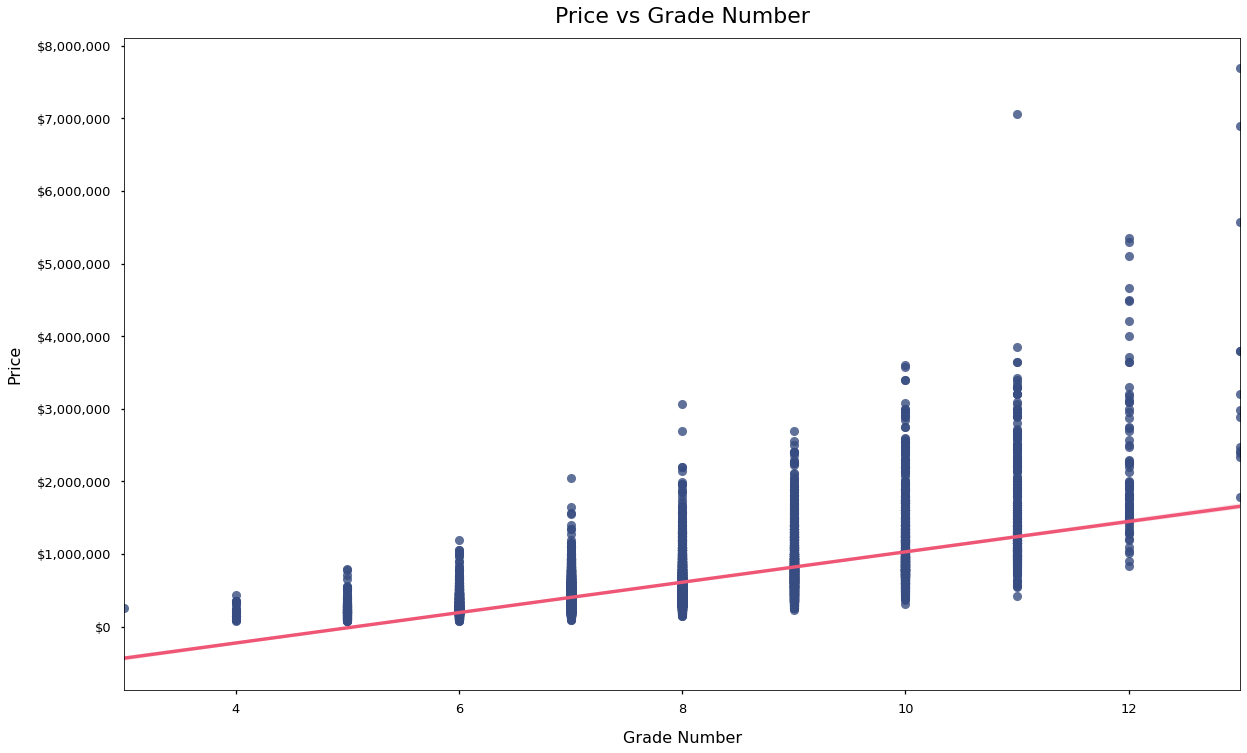

In [47]:
# Let's take a quick look at price vs living area square footage.

fig, ax = plt.subplots(figsize=(20,12))

sns.regplot(x='grade_num',
            y='price', 
            data=df_clean,
            scatter_kws={"color": c("indigo")}, 
            line_kws={"color": c("peach")})

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Price vs Grade Number', pad=15, fontsize=22)
ax.set_xlabel('Grade Number', labelpad=15, fontsize=16)
ax.set_ylabel('Price', labelpad=15, fontsize=16)

plt.show();

As shown in our correlation matrix, this view also shows a positive relationship between the grade number of a home, and the price.  Thus indicating that if the customers's were to make upgrades (i.e. materials and builds), they could see the benefit when trying to sell their home. 

# Regression Modeling

## Model 1

Will first create a model based on our dataframe as it sits right now.  This will serve as a baseline of what we could potentially improve upon, or maybe not approve on.

In [48]:
# Creating our first regression on basic parameters as a baseline.

# Create target 
target1 = df_clean['price']

# Create predictors
predictors1 = df_clean.drop(['price'], axis=1)

# Create model intercept
predictors_int1 = sm.add_constant(predictors1)

# Fit model to data
model1 = sm.OLS(df_clean['price'],predictors_int1).fit()

In [49]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     2471.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:18:52   Log-Likelihood:            -2.9660e+05
No. Observations:               21597   AIC:                         5.932e+05
Df Residuals:                   21581   BIC:                         5.934e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.011e+06   1.35e+05     51.892      0.000    6.75e+06    7.28e+06
bedrooms      -1.188e+05   4754.683    -24.991      0.000   -1.28e+05    -1.1e+05
bathrooms      1.159e+05   1.35e+04      8.586      0.000    8.95e+04    1.42e+05
sqft_living     389.2911     22.329     17.434      0.000     345.524     433.058
sqft_lot          0.0210      0.053      0.396      0.692      -0.083       0.125
floors         2.966e+04   3929.084      7.549      0.000     2.2e+04    3.74e+04
sqft_above     -135.7037     22.323     -6.079      0.000    -179.458     -91.950
sqft_basement    54.7352     19.837      2.759      0.006      15.853      93.618
yr_built      -4035.6994     68.677    -58.764      0.000   -4170.311   -3901.088
sqft_living15    38.7985      3.686     10.527      0.000      31.574      46.023
sqft_lot15       -0.5063      0.081     -6.256      0.000      -0.665      -0.348
is_renovated    4.07e+04   8671.889      4.693      0.000    2.37e+04    5.77e+04
grade_num      1.258e+05   2326.271     54.093      0.000    1.21e+05     1.3e+05
sqft_a/l       3.957e+05   2.66e+04     14.886      0.000    3.44e+05    4.48e+05
sqft_l/b       -395.8944     24.269    -16.313      0.000    -443.464    -348.325
baths_rnd     -6.186e+04   1.33e+04     -4.636      0.000    -8.8e+04   -3.57e+04
==============================================================================
Omnibus:                    15863.677   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           890732.662
Skew:                           2.984   Prob(JB):                         0.00
Kurtosis:                      33.891   Cond. No.                     4.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Good first test.  Higher r2 than what I was anticipating.  I think we might have some co-linear features impacting our score and helping our model along.  I am concerned that our bathrooms feature has such a high p-value.  Another high p-value is sqft_lot; we can remove this feature as it will not really impact our recommendations to the customers.  Being able to add square footage to your lot isn't always the easiest.  With that being said, I am also going to remove both of the _15 metrics as those are also variables that will not help our customers.

In [50]:
# Removing sqft_living15 and sqft_lot15

df_clean = df_clean.drop(['sqft_lot15', 'sqft_living15'], axis=1)

## Model 2

In [51]:
# Create target

target2 = df_clean['price']

# Create predictors
predictors2 = df_clean.drop(['price'], axis=1)

# Create model intercept
predictors_int2 = sm.add_constant(predictors2)

# Fit model to data
model2 = sm.OLS(df_clean['price'],predictors_int2).fit()

In [52]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2822.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:18:52   Log-Likelihood:            -2.9667e+05
No. Observations:               21597   AIC:                         5.934e+05
Df Residuals:                   21583   BIC:                         5.935e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.982e+06   1.35e+05     51.615      0.000    6.72e+06    7.25e+06
bedrooms      -1.183e+05   4769.815    -24.803      0.000   -1.28e+05   -1.09e+05
bathrooms      1.156e+05   1.35e+04      8.533      0.000     8.9e+04    1.42e+05
sqft_living     390.1597     22.397     17.420      0.000     346.260     434.059
sqft_lot         -0.2115      0.038     -5.581      0.000      -0.286      -0.137
floors         2.497e+04   3891.780      6.417      0.000    1.73e+04    3.26e+04
sqft_above     -120.2947     22.350     -5.382      0.000    -164.103     -76.486
sqft_basement    59.4677     19.897      2.989      0.003      20.467      98.468
yr_built      -4020.7860     68.742    -58.491      0.000   -4155.526   -3886.046
is_renovated   3.771e+04   8696.177      4.336      0.000    2.07e+04    5.48e+04
grade_num      1.332e+05   2233.473     59.658      0.000    1.29e+05    1.38e+05
sqft_a/l       3.869e+05   2.67e+04     14.513      0.000    3.35e+05    4.39e+05
sqft_l/b       -393.8194     24.337    -16.182      0.000    -441.521    -346.118
baths_rnd     -6.222e+04   1.34e+04     -4.650      0.000   -8.85e+04    -3.6e+04
==============================================================================
Omnibus:                    15487.015   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           806140.880
Skew:                           2.898   Prob(JB):                         0.00
Kurtosis:                      32.364   Cond. No.                     3.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A little bit worse, but pretty consistent - .658 vs .655 r2. I am going to remove the outliers from my dependent variable price, to see if we can improve upon the r2 value.  Our p-values are looking good right now as well.  

In [53]:
# Removing outliers, and checking row count compared to what we had above =20439

df_clean_out = df_clean[df_clean['price'].between(lower_bnd, upper_bnd)]

len(df_clean_out)

20439

## Model 3

In [54]:
# Quick check for colinearity

df_clean_out.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,is_renovated,grade_num,sqft_a/l,sqft_l/b,baths_rnd
price,1.000000,0.300832,0.454959,0.621362,0.093554,0.273360,0.529931,0.230675,0.061264,0.081213,0.630980,-0.139485,0.501539,0.443049
bedrooms,0.300832,1.000000,0.504697,0.601457,0.025619,0.160827,0.478118,0.281532,0.166782,0.002276,0.329053,-0.194203,-0.090419,0.491785
bathrooms,0.454959,0.504697,1.000000,0.716700,0.064993,0.502707,0.638466,0.216803,0.544843,0.023136,0.613962,-0.115714,0.448529,0.986264
sqft_living,0.621362,0.601457,0.716700,1.000000,0.159058,0.340518,0.853404,0.369106,0.354009,0.019059,0.705223,-0.206236,0.703416,0.704719
sqft_lot,0.093554,0.025619,0.064993,0.159058,1.000000,-0.017066,0.162765,0.011572,0.042480,0.007383,0.094244,0.026472,0.176788,0.061620
floors,0.273360,0.160827,0.502707,0.340518,-0.017066,1.000000,0.528746,-0.291962,0.511811,-0.003562,0.457583,0.359244,0.269895,0.521280
sqft_above,0.529931,0.478118,0.638466,0.853404,0.162765,0.528746,1.000000,-0.160702,0.462240,-0.002210,0.710129,0.308500,0.612373,0.644027
sqft_basement,0.230675,0.281532,0.216803,0.369106,0.011572,-0.291962,-0.160702,1.000000,-0.149189,0.039616,0.070187,-0.924708,0.239705,0.184412
yr_built,0.061264,0.166782,0.544843,0.354009,0.042480,0.511811,0.462240,-0.149189,1.000000,-0.197410,0.493127,0.201746,0.268447,0.547011
is_renovated,0.081213,0.002276,0.023136,0.019059,0.007383,-0.003562,-0.002210,0.039616,-0.197410,1.000000,-0.014992,-0.032153,0.034418,0.023123


In [55]:
# Looking at absolute values above .75 for removal

abs(df_clean_out.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,is_renovated,grade_num,sqft_a/l,sqft_l/b,baths_rnd
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,True
sqft_living,False,False,False,True,False,False,True,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,True,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,True,False,False,False,True,False,False
yr_built,False,False,False,False,False,False,False,False,True,False,False,False,False,False
is_renovated,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [56]:
# Save absolute value of correlation matrix as a data frame

df = df_clean_out.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# Zip the variable name columns
df['pairs'] = list(zip(df.level_0, df.level_1))

# Set index to pairs
df.set_index(['pairs'], inplace = True)

# Drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# Rename correlation column as cc rather than 0
df.columns = ['cc']

# Drop duplicates
df.drop_duplicates(inplace=True)

In [57]:
df[(df.cc >.75) & (df.cc <1)]

,cc
pairs,
"(bathrooms, baths_rnd)",0.986264
"(sqft_basement, sqft_a/l)",0.924708
"(sqft_above, sqft_living)",0.853404


In [58]:
final_df = df_clean_out.drop(['sqft_above',
                              'sqft_a/l',
                              'baths_rnd'], axis=1)
final_df.shape

(20439, 11)

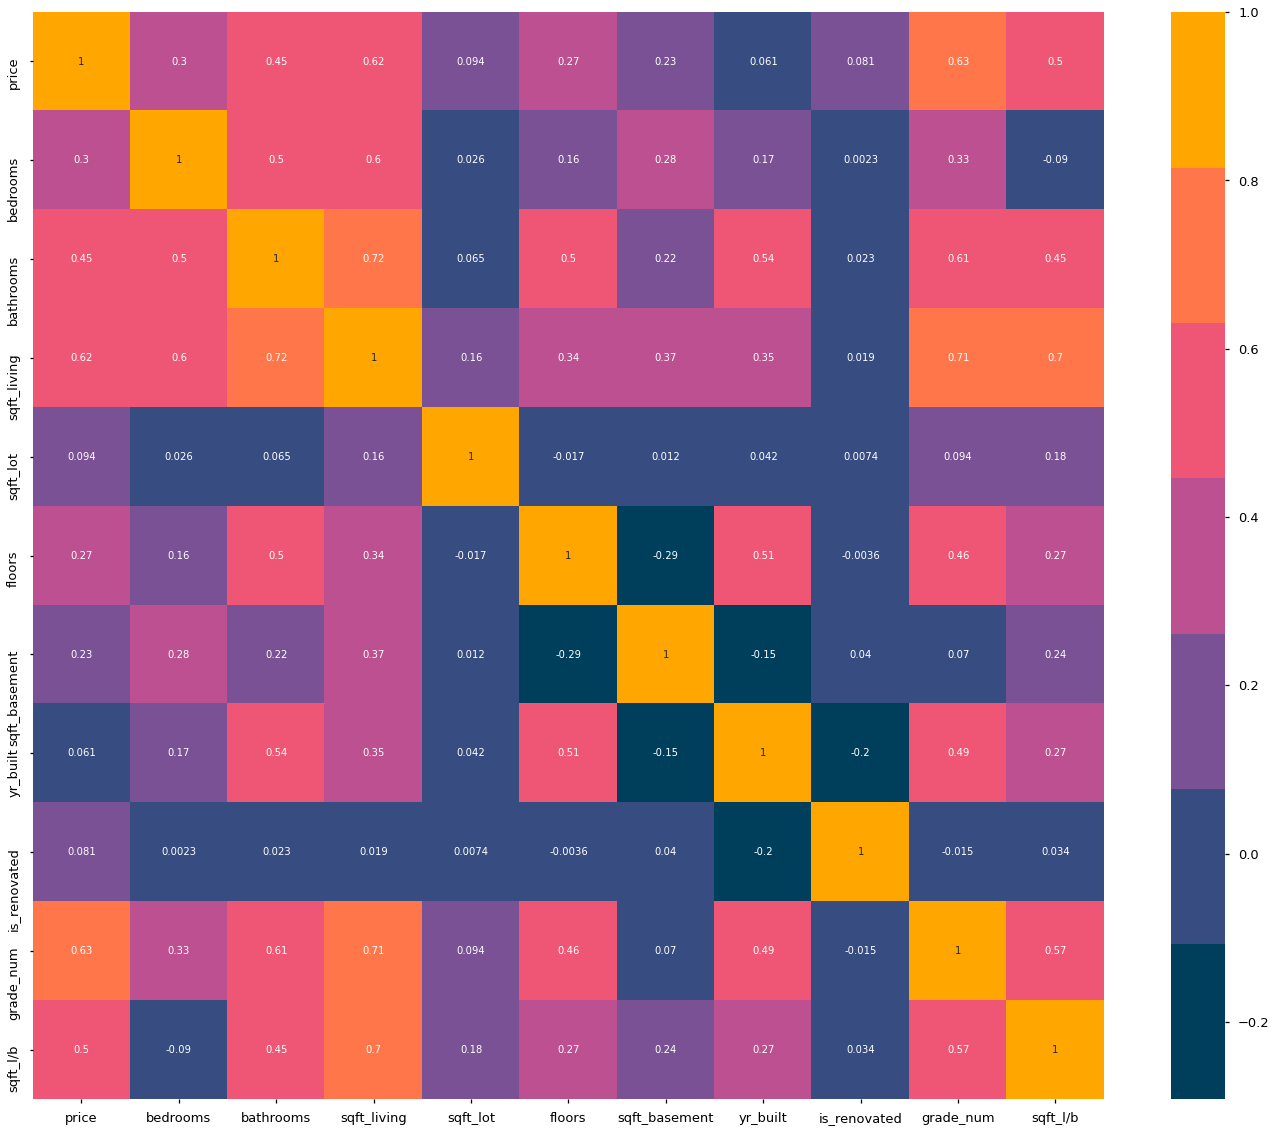

In [59]:
plt.figure(figsize = (24,20))
corrM = final_df.corr()

sns.heatmap(corrM, annot=True, cmap=pal)
plt.show()

Looks like with the changes we have made we are still maintaining our relationships with our dependent variable.  The baths_rnd, sqft_living, and grade_num are all consistent with our initial correlation matrix.


In [60]:
# Model 3 includes same variables excluding price outliers

# create target
target3 = final_df['price']

# create predictors
predictors3 = final_df.drop(['price'], axis=1)

# create model intercept
predictors_int3 = sm.add_constant(predictors3)

# fit model to data
model3 = sm.OLS(final_df['price'],predictors_int3).fit()

In [61]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     2602.
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:18:54   Log-Likelihood:            -2.7087e+05
No. Observations:               20439   AIC:                         5.418e+05
Df Residuals:                   20428   BIC:                         5.418e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.975e+06   8.72e+04     57.079      0.000     4.8e+06    5.15e+06
bedrooms      -1.469e+04   3256.618     -4.512      0.000   -2.11e+04   -8309.609
bathrooms      2.911e+04   2354.778     12.364      0.000    2.45e+04    3.37e+04
sqft_living      80.3567      5.431     14.797      0.000      69.712      91.001
sqft_lot          0.0436      0.025      1.764      0.078      -0.005       0.092
floors         4.258e+04   2471.739     17.229      0.000    3.77e+04    4.74e+04
sqft_basement    25.7348      3.052      8.432      0.000      19.752      31.717
yr_built      -2799.9482     45.365    -61.720      0.000   -2888.867   -2711.029
is_renovated   1536.3157   5810.485      0.264      0.791   -9852.700    1.29e+04
grade_num      1.024e+05   1472.237     69.522      0.000    9.95e+04    1.05e+05
sqft_l/b         15.7406     16.702      0.942      0.346     -16.996      48.477
==============================================================================
Omnibus:                      902.165   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1277.633
Skew:                           0.427   Prob(JB):                    3.68e-278
Kurtosis:                       3.877   Cond. No.                     3.85e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
# Removing columns with > .05 p values and going to rerun model 3

final_df = final_df.drop(['sqft_l/b', 
                          'sqft_lot'], 
                          axis=1)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20439 entries, 0 to 21596
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20439 non-null  float64
 1   bedrooms       20439 non-null  int64  
 2   bathrooms      20439 non-null  float64
 3   sqft_living    20439 non-null  int64  
 4   floors         20439 non-null  float64
 5   sqft_basement  20439 non-null  float64
 6   yr_built       20439 non-null  int64  
 7   is_renovated   20439 non-null  int64  
 8   grade_num      20439 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.6 MB


## Model 3b

In [63]:
# taking a look at our frame once again for final summary stats in presentation.
# Still not satisfied with r2, going to look at yr_built to see if there are any
# additional insights to remove potential outliers.

final_df.describe()

,price,bedrooms,bathrooms,sqft_living,floors,sqft_basement,yr_built,is_renovated,grade_num
count,2.043900e+04,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000,20439.000000
mean,4.767026e+05,3.329468,2.051886,1975.189931,1.475561,261.425950,1970.805079,0.030579,7.530652
std,2.077903e+05,0.884165,0.710196,773.797924,0.536629,406.064503,29.159010,0.172178,1.036060
min,7.800000e+04,1.000000,0.500000,370.000000,1.000000,0.000000,1900.000000,0.000000,3.000000
25%,3.150000e+05,3.000000,1.500000,1400.000000,1.000000,0.000000,1951.000000,0.000000,7.000000
50%,4.375000e+05,3.000000,2.000000,1860.000000,1.000000,0.000000,1974.000000,0.000000,7.000000
75%,6.000000e+05,4.000000,2.500000,2430.000000,2.000000,500.000000,1996.000000,0.000000,8.000000
max,1.120000e+06,11.000000,7.500000,7480.000000,3.500000,2720.000000,2015.000000,1.000000,12.000000


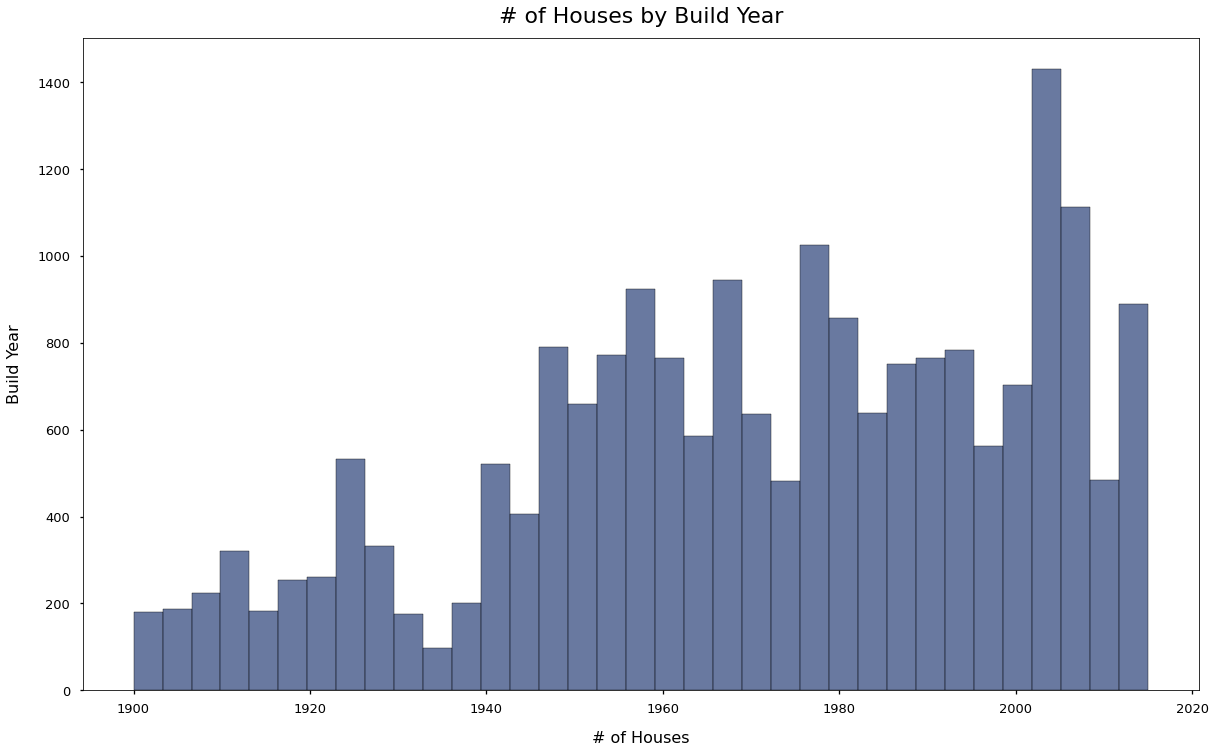

In [64]:
# Taking a look at the number of houses by build year.

fig, ax = plt.subplots(figsize = (20,12))

sns.histplot(data=final_df, x='yr_built', color = c("indigo"))

ax.set_title('# of Houses by Build Year', pad = 15, fontsize = 22)
ax.set_xlabel('# of Houses', labelpad = 15, fontsize = 16)
ax.set_ylabel('Build Year', labelpad = 15, fontsize = 16) 
plt.show();

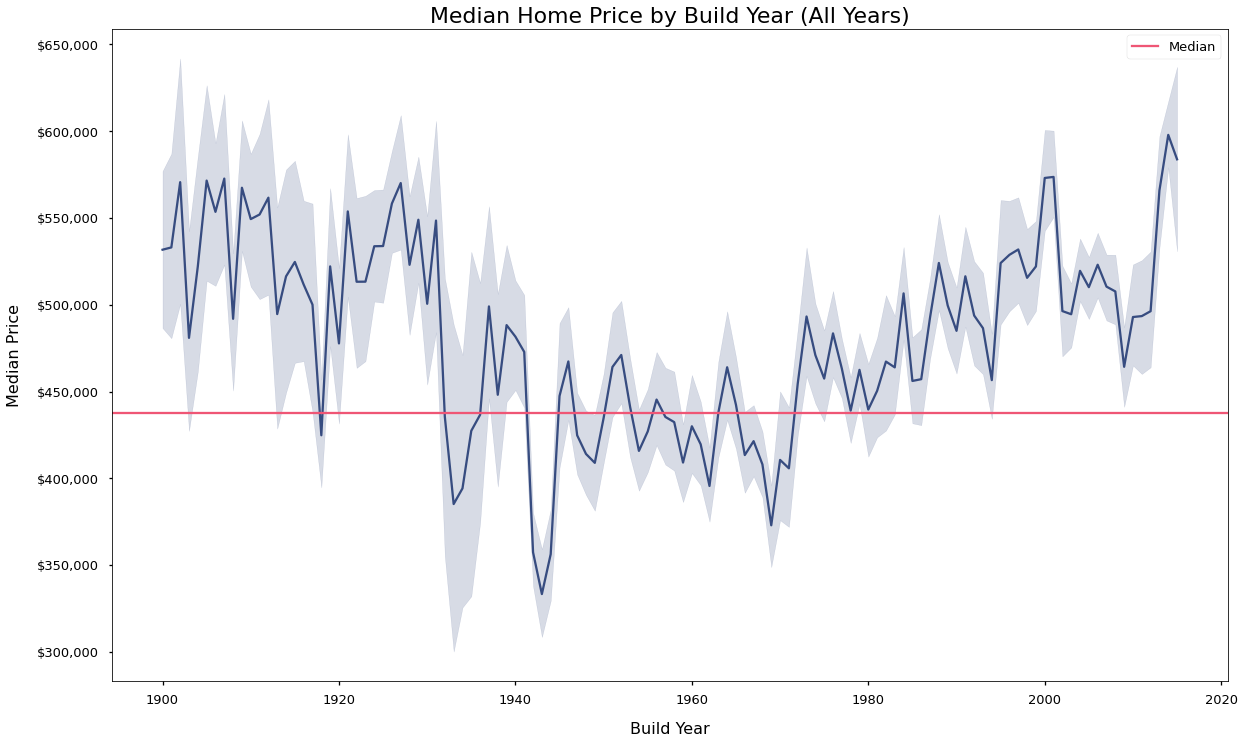

In [65]:
# Now that we know the value counts by year, I am going to take a look at the median 
# values by year to look how that is changing over time.  The tricky part here is that we don't
# know necessarily when the price value is represented.  

fig, ax = plt.subplots(figsize = (20,12))


sns.lineplot(x='yr_built',
            y='price',
            data=final_df,
            ax=ax,
            color=c('indigo'))

plt.axhline(final_df['price'].median(), color = c("peach"), label = 'Median')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Median Home Price by Build Year (All Years)', fontsize = 22)
ax.set_xlabel('Build Year', labelpad = 15, fontsize = 16)
ax.set_ylabel('Median Price', labelpad = 15, fontsize = 16) 
plt.legend()

plt.show();

What is interesting is that median values are similar from years 1900 - 1935ish, and from 1990 to the end of our dataset in 2015.  Going to look at removing the values before 1990 to see if we can increase the relationship between price and yr_built, without sacrificing any sort of colinear relationship.  There is probably also something to be said around how houses were constructed in these different time periods.

In [66]:
# Looks like price bounces around quite a bit when comparing records, and yr_built
# Going to adjust my dataframe to include more recent housing prices

final_df_recent = final_df.loc[final_df['yr_built'] >= 1990]

In [67]:
final_df_recent.describe()

,price,bedrooms,bathrooms,sqft_living,floors,sqft_basement,yr_built,is_renovated,grade_num
count,6.463000e+03,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,5.187825e+05,3.449636,2.565720,2321.461396,1.992109,121.717314,2002.830419,0.000464,8.183197
std,2.054968e+05,0.798226,0.510816,820.258728,0.432650,292.102191,7.017290,0.021542,0.985589
min,1.540000e+05,1.000000,0.500000,550.000000,1.000000,0.000000,1990.000000,0.000000,5.000000
25%,3.500000e+05,3.000000,2.500000,1670.000000,2.000000,0.000000,1997.000000,0.000000,7.000000
50%,4.750000e+05,3.000000,2.500000,2240.000000,2.000000,0.000000,2004.000000,0.000000,8.000000
75%,6.525500e+05,4.000000,2.750000,2860.000000,2.000000,0.000000,2008.000000,0.000000,9.000000
max,1.120000e+06,9.000000,7.500000,7350.000000,3.500000,2600.000000,2015.000000,1.000000,12.000000


In [68]:
# Creating a data frame for a chart below

yr_chrt = (
    final_df_recent
    .groupby('yr_built')['price']
    .median()
    .reset_index()
    )

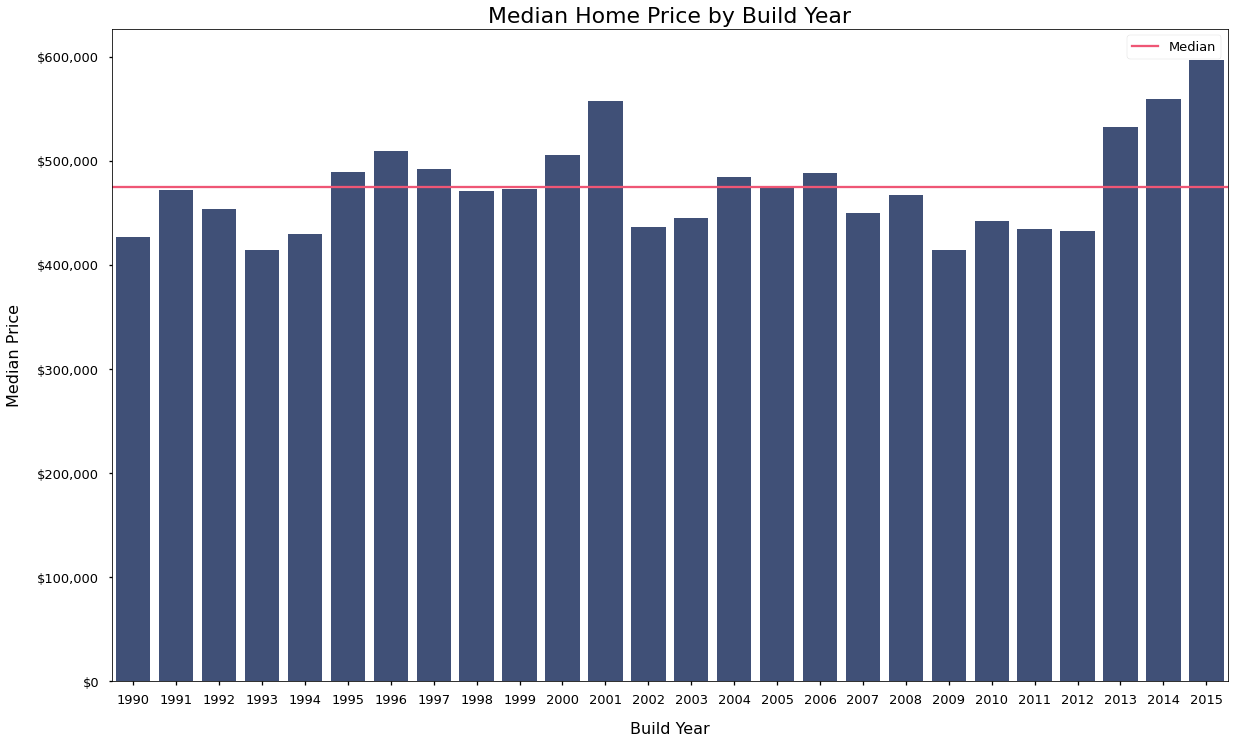

In [69]:
# creating visual for presentaiton.  Showing median home values over time for 
# reference to show that they really don't fluctuate much above or below the median
# for the entire time frame.

fig, ax = plt.subplots(figsize = (20,12))


sns.barplot(x='yr_built',
            y='price',
            data=yr_chrt,
            color = c("indigo"),
            ax=ax)

plt.axhline(final_df_recent['price'].median(), color = c("peach"), label = 'Median')


fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Median Home Price by Build Year', fontsize = 22)
ax.set_xlabel('Build Year', labelpad = 15, fontsize = 16)
ax.set_ylabel('Median Price', labelpad = 15, fontsize = 16) 
plt.legend()

plt.show();

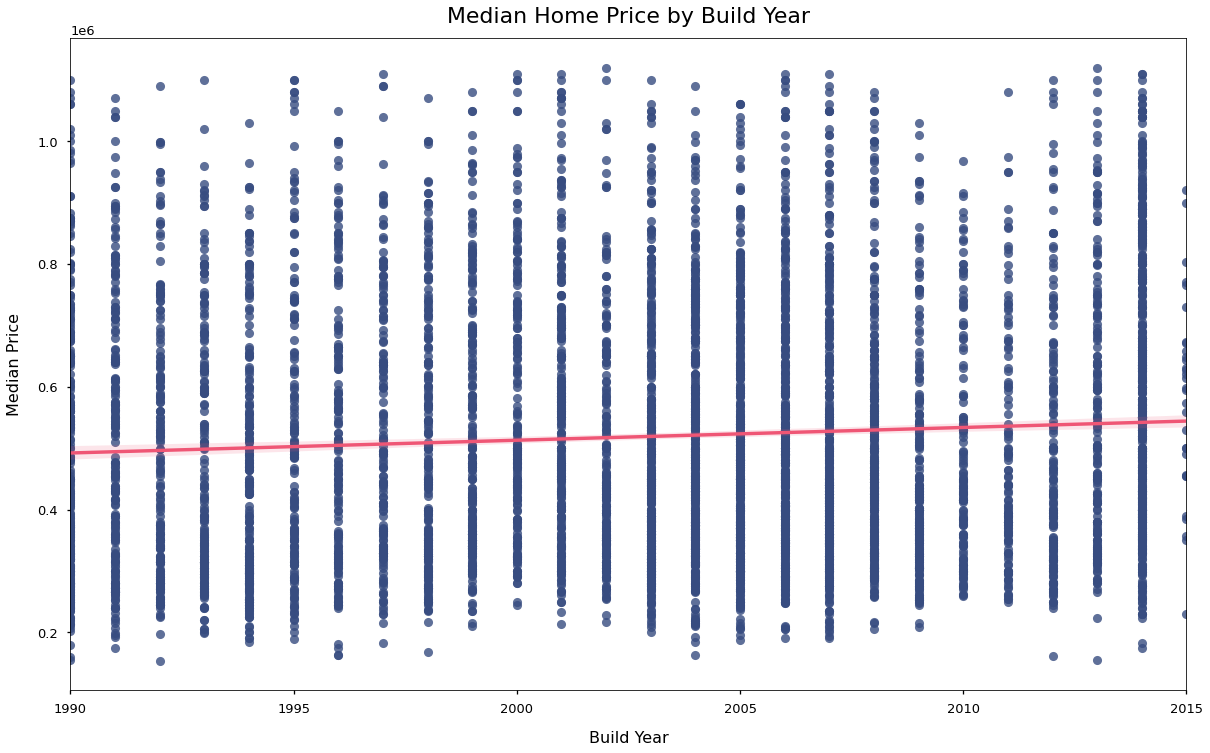

In [70]:
# Taking a look at our median home prices by build year

fig, ax = plt.subplots(figsize = (20,12))

sns.regplot(x='yr_built',
            y='price', 
            data=final_df_recent,
            scatter_kws={"color": c("indigo")}, 
            line_kws={"color": c("peach")})

ax.set_title('Median Home Price by Build Year', pad = 15, fontsize = 22)
ax.set_xlabel('Build Year', labelpad = 15, fontsize = 16)
ax.set_ylabel('Median Price', labelpad = 15, fontsize = 16) 

plt.show();

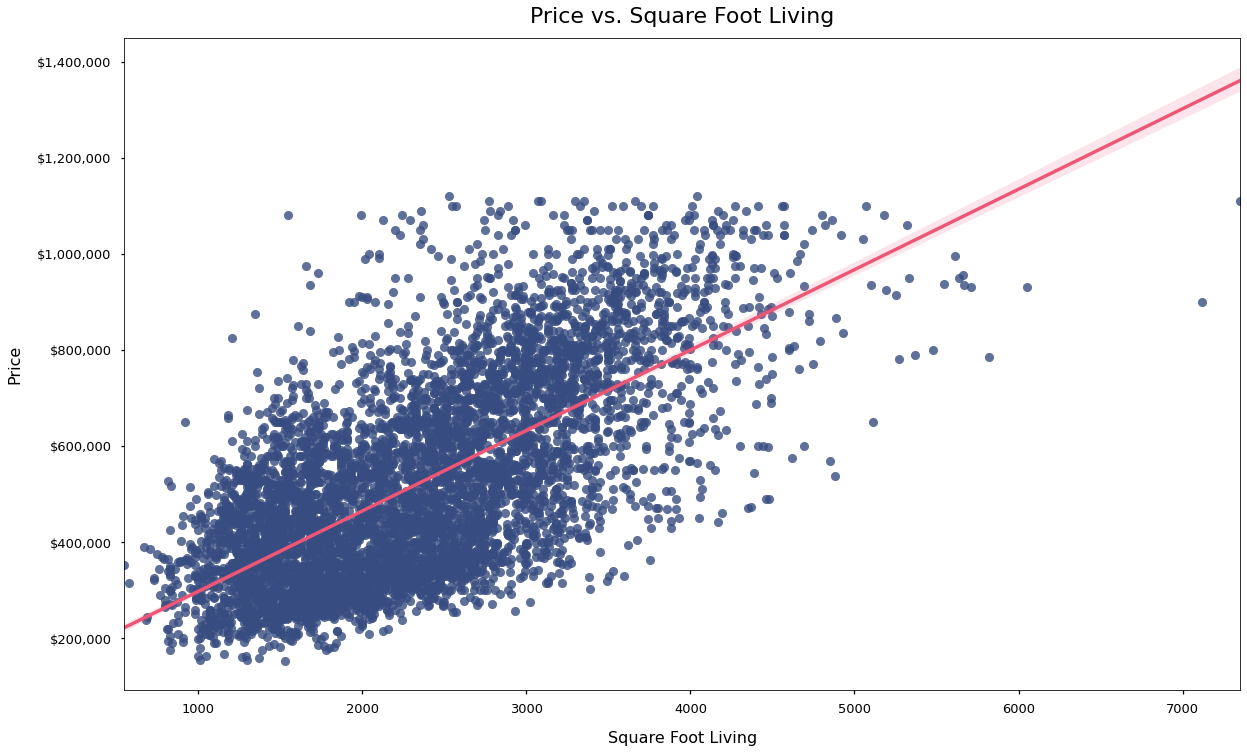

In [71]:
# Looking at the relationship between price and square foot living.  This will
# be a good visual for our presentation.

fig, ax = plt.subplots(figsize = (20,12))

sns.regplot(x='sqft_living',
            y='price', 
            data=final_df_recent,
            scatter_kws={"color": c("indigo")}, 
            line_kws={"color": c("peach")})

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Price vs. Square Foot Living', pad = 15, fontsize = 22)
ax.set_xlabel('Square Foot Living', labelpad = 15, fontsize = 16)
ax.set_ylabel('Price', labelpad = 15, fontsize = 16) 
plt.show();

In [73]:
# Quick peek

baths_chrt

,bathrooms,price
0,0.50,312500.0
1,0.75,363550.5
2,1.00,318250.0
3,1.25,528250.0
4,1.50,358500.0
5,1.75,358500.0
6,2.00,369725.0
7,2.25,400000.0
8,2.50,461000.0
9,2.75,599000.0


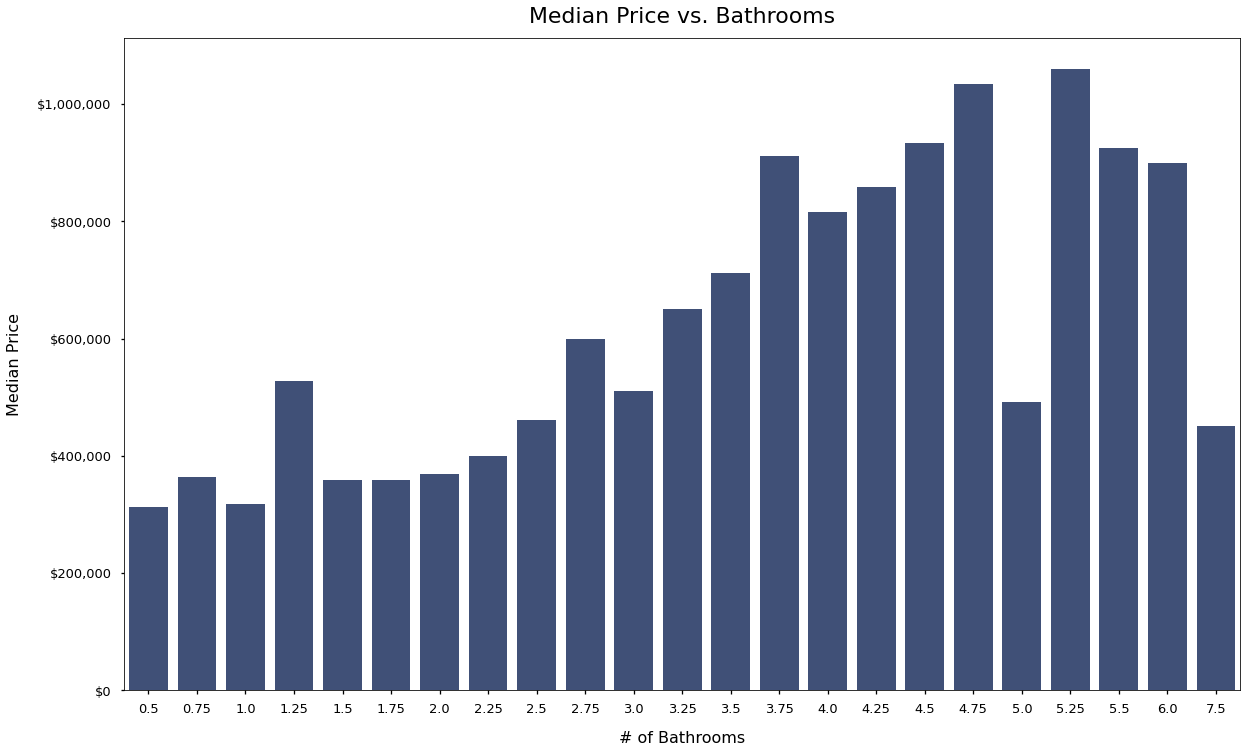

In [74]:
# Visual for presentation -- visualizing data from above data frame.

fig, ax = plt.subplots(figsize = (20,12))

sns.barplot(x='bathrooms',
            y='price', 
            data=baths_chrt,
            color=c('indigo')
           )

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.set_title('Median Price vs. Bathrooms', pad = 15, fontsize = 22)
ax.set_xlabel('# of Bathrooms', labelpad = 15, fontsize = 16)
ax.set_ylabel('Median Price', labelpad = 15, fontsize = 16) 
plt.show();

In [75]:
# Taking a quick look at price per square foot.  Just need a value for presentation

final_df_recent['price_per_sqft'] = final_df_recent.loc['price']/ final_df_recent.loc['sqft_living']
final_df_recent['price_per_sqft'].median()


KeyError: 'price'

In [ ]:
# Model 3b - removed outliers, combined with a round of feature removal, and final dataset of 
# > 1990 values.

# create target
target3b = final_df_recent['price']

# create predictors
predictors3b = final_df_recent.drop(['price'], axis=1)

# create model intercept
predictors_int3b = sm.add_constant(predictors3b)

# fit model to data
model3b = sm.OLS(final_df_recent['price'],predictors_int3b).fit()

In [ ]:
model3b.summary()

In [ ]:
final_df_recent = final_df_recent.drop(['is_renovated'], axis=1)

In [ ]:
# Model 3b - removed outliers, combined with features with p values > .05.  What I am
# assuming should be our final model.  Finally removed is_renovated

# create target
target3b = final_df_recent['price']

# create predictors
predictors3b = final_df_recent.drop(['price'], axis=1)

# create model intercept
predictors_int3b = sm.add_constant(predictors3b)

# fit model to data
model3b = sm.OLS(target3b,predictors_int3b).fit()

In [ ]:
model3b.summary()

Here we go -- 3b is our model.  It seems to have the highest r2, and our p-value meet the requirements of our testing.  Even though the r2 isn't super high, I think we still know enough to make recommendations to our customers on which features within a home will most contribute to the Price.  I will be adding some limitations to my presentation as well as at the end of the presentation of the dos and do nots of this final output.

Insights for presentation

* bathrooms increase the value of the home by $21,420


* sqft_living increases the value of a home by $101 per square foot


* increasing the grade of your home by 1, increases the value by $99k


* bedrooms decrease the value of a home by $32,220


* adding floors to your home adds $ 27,300 per floor


* newer homes generally get more money than the older in this dataset.  However, this is not an impactable feature.


### Checking Linear Regression Assumptions

In [ ]:
# Plotting residuals on qq plot to understand linearity

fig, ax = plt.subplots(figsize = (20,12))

res = model3b.resid # residuals

sm.qqplot(res, fit=True, line='45', ax=ax);

In [ ]:
# Looking at the overall distribution of residuals

fig, ax = plt.subplots(figsize = (20,12))

sns.histplot(data=res, kde=True, color=c("indigo"))

In [ ]:
# fitting our model using ski-kit learn here to do create some predictions

lr.fit(predictors3b, target3b)

In [ ]:
# Creating a quick prediction and taking a look at the array

y_hat = lr.predict(predictors3b)
y_hat

In [ ]:
# Looking for homoskedasticity within our residuals (difference between predicted
# and original values)

fig, ax = plt.subplots(figsize = (20,12))

resid = (target3b - y_hat)
plt.scatter(x=range(y_hat.shape[0]), y=resid, alpha=0.1, color=c("indigo"))

### Colinearity Check

In [ ]:
# Checking for any colinear features after our most recent updates to the model

final_df_recent.corr()

In [ ]:
# Create absolute values to understand if any features are above .75 r2

abs(final_df_recent.corr()) > 0.75

In [ ]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=final_df_recent.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [ ]:
df[(df.cc >.75) & (df.cc <1)]

In [ ]:
plt.figure(figsize = (24,15))
corr = final_df_recent.corr()

sns.heatmap(corr, annot=True, cmap=pal)
plt.show()

That is a beautiful loooking heatmap.  Independent variables identified earlier are still holding strong. 

## Model3c

One last feature log transforming our price dependent variable to try and normalize one last time.

In [ ]:
# Log transforming the price column

final_df_recent['price_log'] = np.log(final_df_recent['price'])
final_df_recent = final_df_recent.drop(['price'], axis=1)
final_df_recent.info()

In [ ]:
# Model 3b - removed outliers, combined with features with p values > .05

# create target
target3c = final_df_recent['price_log']

# create predictors
predictors3c = final_df_recent.drop(['price_log'], axis=1)

# create model intercept
predictors_int3c = sm.add_constant(predictors3c)

# fit model to data
model3c = sm.OLS(target3c,predictors_int3c).fit()

In [ ]:
model3c.summary()

# Predictions

Going back to our final model 3b to understand mean errors, and any train/ test information.  This is not as important for the analysis that we completed.  However, I am executing here in the event there are questions around capability and model performance.

In [ ]:
# Looking at mean absolute error

metrics.mean_absolute_error(target3b, y_hat)

In [ ]:
# Looking at mean squared error

metrics.mean_squared_error(target3b, y_hat, squared=False)

In [ ]:
# Creating a test/ train split of 80/20 for both our predictors and dependent features

X_train, X_test, y_train, y_test = train_test_split(predictors3b, target3b, test_size=0.20)
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
# Fitting our train/ test splits

lr.fit(X_train, y_train)

# Create price predictions on train and test data from the independant variables
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)

In [ ]:
# Create train & test residuals

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [ ]:
# Compute MSE for train and test set

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)

print('Train Mean Squared Error: ', mse_train)
print('Test Mean Squared Error: ', mse_test)

In [ ]:
# 

plt.figure(figsize=(20, 12))

plt.scatter(y_train, y_hat_train, label='Model', color=c("indigo"))

plt.plot(y_train, y_train, label='Actual', color=c("peach"))
plt.title('Model vs Training Data')
plt.legend()

In [ ]:
# Create a matplotlib figure

plt.figure(figsize=(20,12))

plt.scatter(y_test, y_hat_test, label='Model', color=c("indigo"))
plt.plot(y_train, y_train, label='Actual', color=c("peach"))
plt.title('Model vs Test set')
plt.legend()

# Additional Models

## 3b - Cohort 1 Regression (< 1932)

In [ ]:
# Looking at values prior to 1932. Trying to understand the data sets as we have defined
# the splits for the final dataset.

final_df_old = final_df.loc[final_df['yr_built'] < 1932]
final_df_old.describe()

In [ ]:
# This is the "Old Dataset/ cohort" that has the final independent variables
# as 3b.

# create target
target5old = final_df_old['price']

# create predictors
predictors5old = final_df_old.drop(['price'], axis=1)

# create model intercept
predictors_int5old = sm.add_constant(predictors5old)

# fit model to data
model5old = sm.OLS(target5old,predictors_int5old).fit()

In [ ]:
# Summary of our regression

model5old.summary()

## 3b - Cohort 2 Regression (1932-1990)

In [ ]:
# Looking at values from 1932 to 1990.  This is my second of the 3 cohorts to understand
# what data is really hurting my model.

final_df_middle = final_df.loc[(final_df['yr_built'] >= 1932) & (final_df['yr_built'] < 1990)]
final_df_middle.describe()

In [ ]:
# model 3b - removed outliers, combined with features with p values > .05

# create target
target5mid = final_df_middle['price']

# create predictors
predictors5mid = final_df_middle.drop(['price'], axis=1)

# create model intercept
predictors_int5mid = sm.add_constant(predictors5mid)

# fit model to data
model5mid = sm.OLS(target5mid,predictors_int5mid).fit()

In [ ]:
model5mid.summary()

# Conclusion

In conclusion, we were able to evaluate and identify a few different options for our customer and ultimately some recommendations that they can make to the clients about increasing the value of their home.  


- **The median home price in King County, WA is 475k dollars**
- **By increasing the living square footage of your home, you can increase the value by 99 dollars per square foot.**
- **By adding bathrooms, and adding 1/4 bath features, you can increase the value of your home by 22 dollars for each 1/4 bath you add.**



There are a few additional analyses that we could do moving forward to identify additional features, and those are:

- **Address limitations/ concerns - add additional pricing data, adjust for inflation, etc.**
- **Look at additional zip codes to understand values more specifically (or not).**
- **Evaluate additional variables/ features such as environmental, or other factors that may have an impact on a home’s value.**
- **Refresh the analysis regularly with new data to understand how the market is evolving over time.**